# Yelp Reviews: Classification of 1 & 2 vs 5 Stars on Reviews - XGBoost GPU
## Optuna Hyperparameter Optimization

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gensim==3.8.3
!pip install xgboost==1.5.2
!pip install optuna
import os
import random
import numpy as np
import warnings
import pandas as pd
from datetime import datetime, timedelta
from timeit import default_timer as timer
from gensim.models import Word2Vec, KeyedVectors
import multiprocessing
import pickle
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import optuna
from optuna import Trial
from sklearn.metrics import log_loss, accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score classification_report, confusion_matrix
import plotly.offline as py
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING) # use INFO to see progress
my_dpi = 96

In [ ]:
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi
print('\n')
cores = multiprocessing.cpu_count()
print('Number of cores:', cores)

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Fri Apr 15 16:55:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    13W /  70W |      0MiB / 15109MiB |      0%      Default |
|            

In [ ]:
# Set seed 
seed_value = 42
os.environ['YelpReviews_ML'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/

/content/drive/MyDrive/Yelp_Reviews/Data


In [ ]:
# Read tokenized reviews with stars filtered to 1, 2 and 5
df = pd.read_parquet('YelpReviews_NLP_125stars_tokenized.parquet')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (1541486, 2)


stars_reviews                                        cleanReview
index                                                                  
2                5.0  [wonderful, place, get, lunch, staff, friendly...
3                5.0  [dedicated, loving, memory, gary, feldman, gre...
5                5.0  [love, place, everything, menu, delicious, lik...
7                5.0  [truely, hidden, gem, place, greatest, buffalo...
9                5.0  [seriously, great, fresh, fantastic, food, spo...

In [ ]:
# Process format of reviews for word2vec
df["cleanReview"]= [[f'"{j}"' for j in i] for i in df["cleanReview"]]
df.head()

stars_reviews                                        cleanReview
index                                                                  
2                5.0  ["wonderful", "place", "get", "lunch", "staff"...
3                5.0  ["dedicated", "loving", "memory", "gary", "fel...
5                5.0  ["love", "place", "everything", "menu", "delic...
7                5.0  ["truely", "hidden", "gem", "place", "greatest...
9                5.0  ["seriously", "great", "fresh", "fantastic", "...

In [ ]:
# Recode to binary
df['stars_reviews'].mask(df['stars_reviews'] == 1, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 2, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 5, 1, inplace=True)

print('Number of reviews per group:')
df[['stars_reviews']].value_counts() 

Number of reviews per group:


stars_reviews
0.0              770743
1.0              770743
dtype: int64

In [ ]:
# Shuffle and sample 1 & 2 star reviews
df1 = df[df.stars_reviews==0]
df1 = shuffle(df1)
df1 = df1.sample(n=414937)

In [ ]:
# Shuffle and sample 5 star reviews
df2 = df[df.stars_reviews==1]
df2 = shuffle(df2)
df2 = df2.sample(n=414937)

# Concat with 1 and 2 star reviews
df = pd.concat([df1, df2])
df = shuffle(df)

del df1, df2

df.shape

(829874, 2)

In [ ]:
# Set up label and features
label = df[['stars_reviews']]
features = df.cleanReview

## Word2vec - Reviews: 50 epochs

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

/content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models


In [ ]:
# Load model
word2vec_path = 'gensim_w2vModel_review125_50epochs.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
# Save embedded word vector space
wv = model.wv
print(len(wv.vocab), 'unique words in the dataset.')

373847 unique words in the dataset.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



In [ ]:
# Creating Mean Word Embeddings using Mean Embedding Vectorizer class
class W2vVectorizer(object):
    """
    This class is used to provide mean word vectors for text. 
    The transform function generates mean vectors in model pipelines.
    The class has both fit & transform functions for use in a sklearn Pipeline.
    """
    
    def __init__(self, w2v):
        self.w2v = w2v
        
        # If using GloVe, the model is in a dictionary format
        if isinstance(w2v, dict):
            if len(w2v) == 0:
                self.dimensions = 0
            else:
                self.dimensions = len(w2v[next(iter(w2v))])
        # Otherwise, using gensim keyed vector
        else:
            self.dimensions = w2v.vector_size
    
    # Implement a fit method required for sklearn Pipeline.
    def fit(self, X, y):
        return self

    def transform(self, X):
        """
        Generates a w2v vector for a set of tokens by taking 
        the mean of each token in the review.
        """
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                    or [np.zeros(self.dimensions)], axis=0) for words in X])

In [ ]:
print('Pipeline for Word2Vec:')
pl  = Pipeline([('W2vVectorizer', W2vVectorizer(wv))])
pl

Pipeline for Word2Vec:


Pipeline(steps=[('W2vVectorizer',
                 <__main__.W2vVectorizer object at 0x7f70308d5750>)])

In [ ]:
def train_model_for_study(features, label, model):
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        label, 
        test_size=0.2, 
        stratify=label,
        random_state=seed_value)

    # Vectorize
    X_train = pl.fit_transform(X_train)
    X_test = pl.fit_transform(X_test)
    
    # Start timer for each trial
    start = timer()

    # Fit model
    model.fit(
        X_train, 
        y_train.values.ravel(),
        eval_set=[(X_test, y_test.values.ravel())])
    run_time = timer() - start

    # Predictions
    y_pred_val = model.predict_proba(X_test)
    cv_scores = log_loss(y_test, y_pred_val)     
    print('- Validation logloss:', np.mean(cv_scores))  
    
    return np.mean(cv_scores)       

### 100 Trials

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/XGBoost/ReviewStars/Model_PKL/

In [ ]:
def xgb_hpo(trial):
    """
    Objective function to tune a `XGBoostClassifier` model.
    """
    joblib.dump(study, 'XGBoost_Optuna_100_GPU.pkl')

    # Define parameter grid
    params_xgboost_optuna = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=10),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_uniform('subsample', 0, 1),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0, 1),
        'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0, 1), 
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10)
        }

    # Define model
    model = XGBClassifier(
        objective='binary:logistic',
        booster='gbtree',  
        tree_method='gpu_hist', 
        scale_pos_weight=1,
        use_label_encoder=False,
        random_state=seed_value,
        verbosity=0,
        **params_xgboost_optuna)
    
    return train_model_for_study(features, label, model)

In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
if os.path.isfile('XGBoost_Optuna_100_GPU.pkl'):
    study = joblib.load('XGBoost_Optuna_100_GPU.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(xgb_hpo, n_trials=100)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Streaming output truncated to the last 5000 lines.
[379]	validation_0-logloss:0.15437
[380]	validation_0-logloss:0.15437
[381]	validation_0-logloss:0.15436
[382]	validation_0-logloss:0.15436
[383]	validation_0-logloss:0.15435
[384]	validation_0-logloss:0.15434
[385]	validation_0-logloss:0.15434
[386]	validation_0-logloss:0.15434
[387]	validation_0-logloss:0.15434
[388]	validation_0-logloss:0.15432
[389]	validation_0-logloss:0.15432
[390]	validation_0-logloss:0.15432
[391]	validation_0-logloss:0.15432
[392]	validation_0-logloss:0.15432
[393]	validation_0-logloss:0.15432
[394]	validation_0-logloss:0.15431
[395]	validation_0-logloss:0.15431
[396]	validation_0-logloss:0.15431
[397]	validation_0-logloss:0.15431
[398]	validation_0-logloss:0.15430
[399]	validation_0-logloss:0.15430
[400]	validation_0-logloss:0.15429
[401]	validation_0-logloss:0.15429
[402]	validation_0-logloss:0.15429
[403]	validation_0-logloss:0.15429
[404]	validation_0-logloss:0.15429
[405]	validation_0-logloss:0.15428
[406

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/XGBoost/ReviewStars/trialOptions/

In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number': 'iteration'}, inplace=True)
trials_df.rename(columns={'value': 'logloss'},inplace=True)
trials_df.rename(columns={'params_colsample_bylevel': 'colsample_bylevel'}, 
                 inplace=True)
trials_df.rename(columns={'params_colsample_bytree': 'colsample_bytree'}, 
                 inplace=True)
trials_df.rename(columns={'params_gamma': 'gamma'}, inplace=True)
trials_df.rename(columns={'params_learning_rate': 'learning_rate'}, 
                 inplace=True)
trials_df.rename(columns={'params_max_depth': 'max_depth'}, inplace=True)
trials_df.rename(columns={'params_min_child_weight': 'min_child_weight'}, 
                 inplace=True)
trials_df.rename(columns={'params_n_estimators': 'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_reg_alpha': 'reg_alpha'}, inplace=True)
trials_df.rename(columns={'params_reg_lambda': 'reg_lambda'}, inplace=True)
trials_df.rename(columns={'params_subsample': 'subsample'}, inplace=True)
trials_df = trials_df.sort_values('logloss', ascending=True)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('XGBoost_Optuna_100_GPU.csv', index=False)

    iteration   logloss             datetime_start          datetime_complete  \
94         94  0.153982 2022-04-14 15:20:14.919072 2022-04-14 15:23:26.132469   
80         80  0.154005 2022-04-14 14:36:00.576219 2022-04-14 14:39:09.247437   
82         82  0.154033 2022-04-14 14:42:19.146308 2022-04-14 14:45:29.632504   
89         89  0.154035 2022-04-14 15:04:22.941991 2022-04-14 15:07:31.249733   
86         86  0.154042 2022-04-14 14:54:56.024230 2022-04-14 14:58:04.053388   
..        ...       ...                        ...                        ...   
0           0  0.654390 2022-04-14 10:39:20.459815 2022-04-14 10:42:10.701400   
6           6  0.664473 2022-04-14 10:56:55.678540 2022-04-14 10:59:40.659019   
7           7  0.679765 2022-04-14 10:59:40.659122 2022-04-14 11:02:32.178440   
8           8  0.685524 2022-04-14 11:02:32.178561 2022-04-14 11:05:17.895993   
3           3  0.687672 2022-04-14 10:47:58.661227 2022-04-14 10:50:48.778887   

                 duration  

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/XGBoost/ReviewStars/Model_Explanations/

In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_XGBoost_Optuna_100_GPU.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_XGBoost_Optuna_100_GPU.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_XGBoost_Optuna_100_GPU.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = optuna.visualization.plot_contour(study, params=['min_child_weight', 
                                                       'max_depth', 
                                                       'learning_rate', 
                                                       'gamma'])
py.plot(fig, filename='contour_XGBoost_Optuna_100_GPU.html')
fig.show()

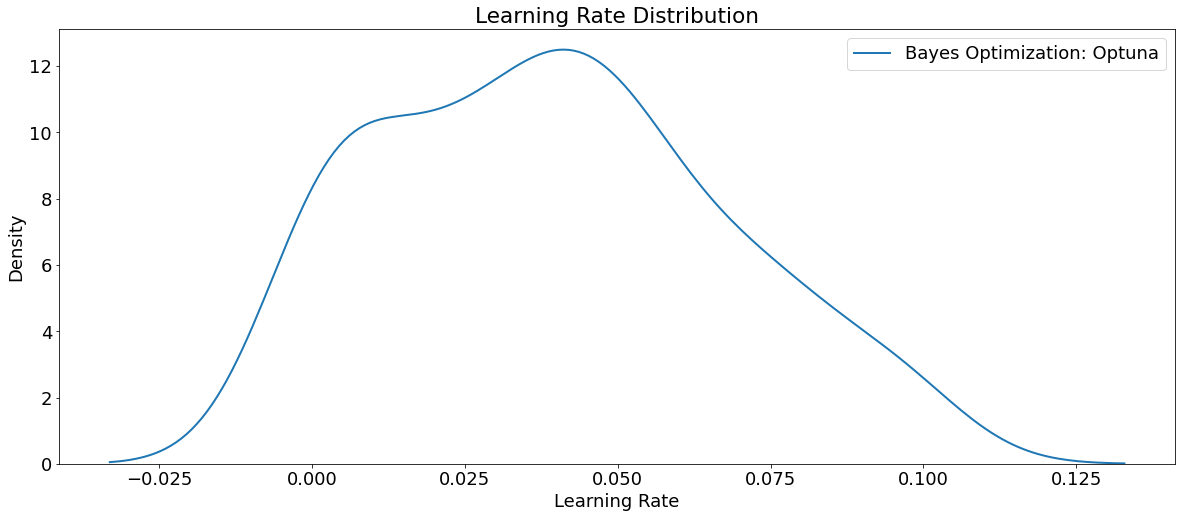

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label='Bayes Optimization: Optuna', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); 
plt.title('Learning Rate Distribution');
plt.show()

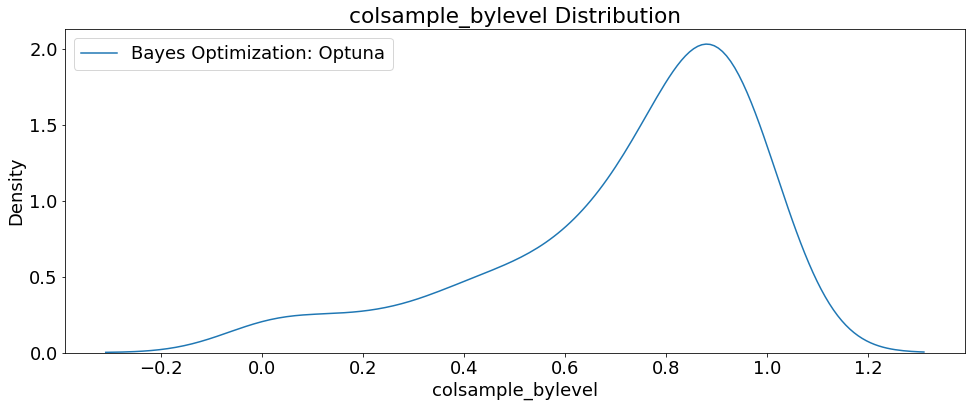

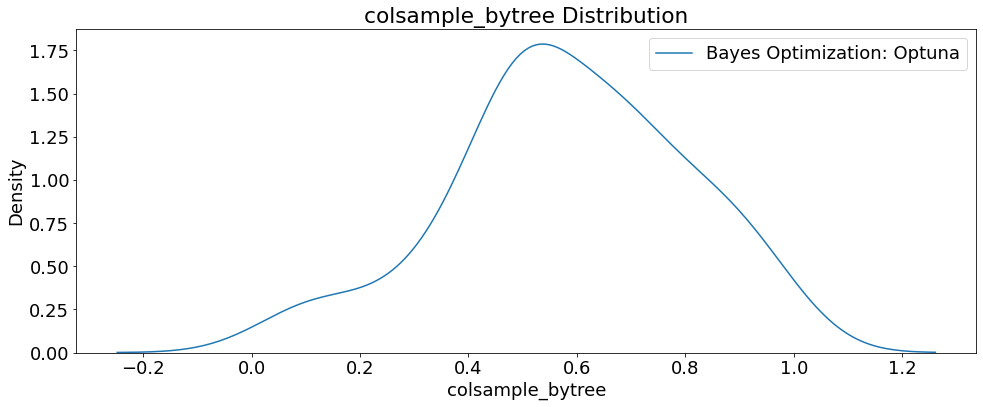

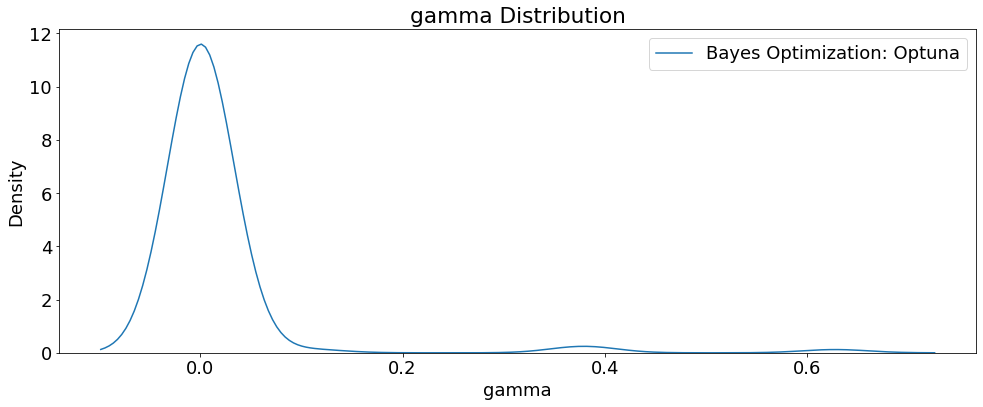

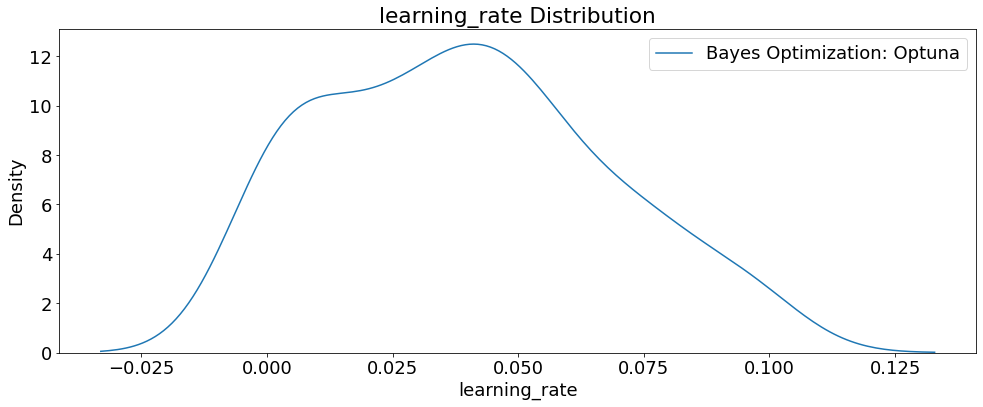

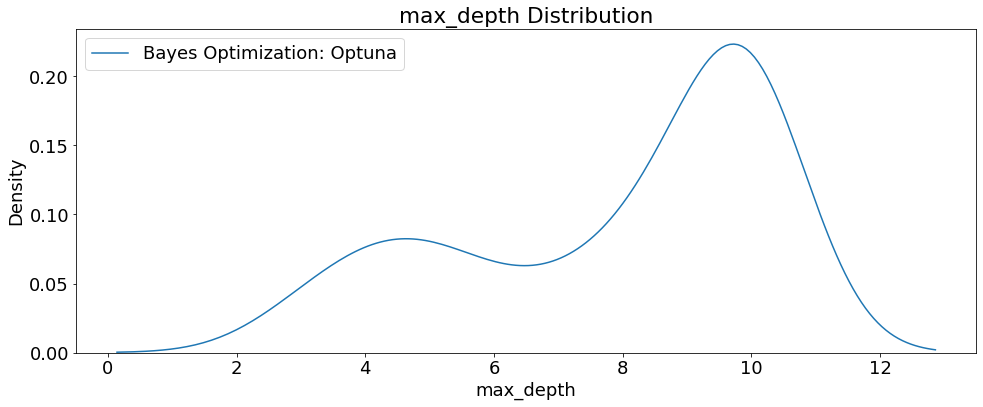

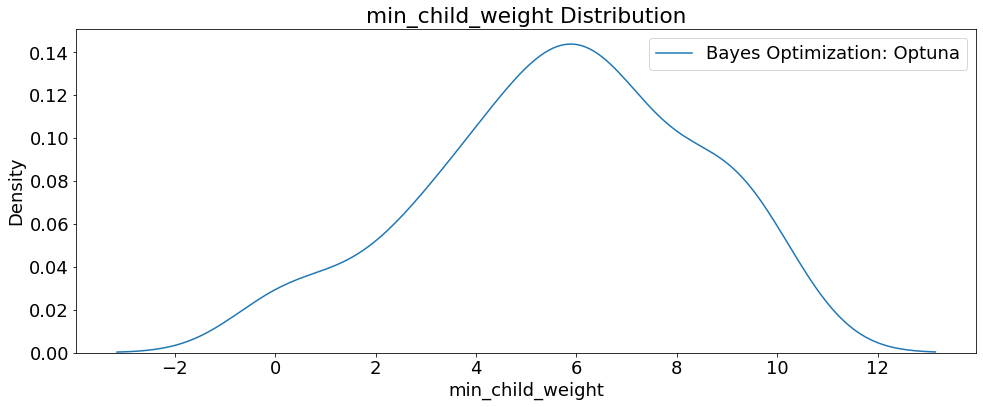

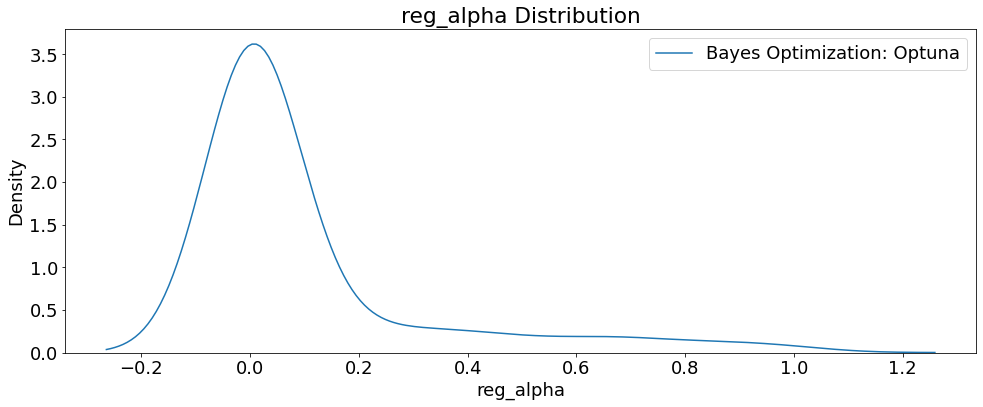

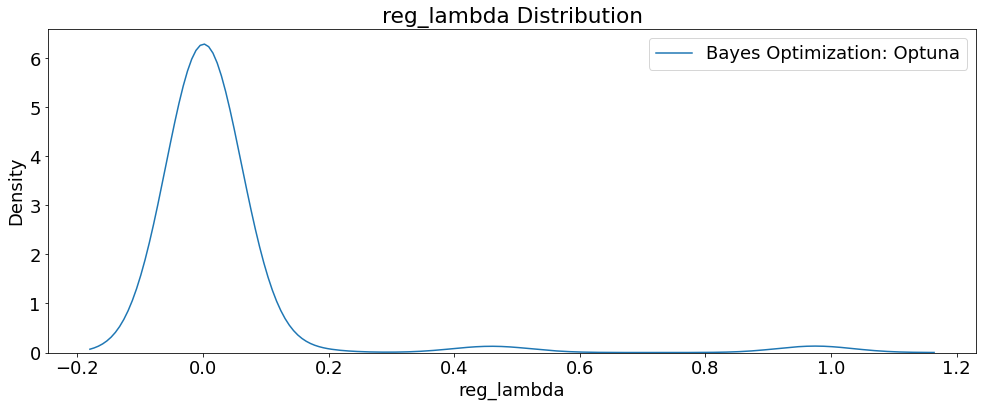

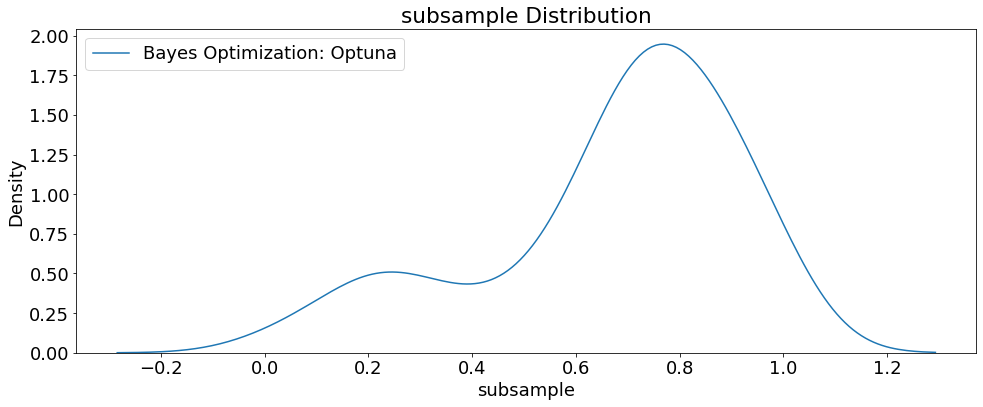

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

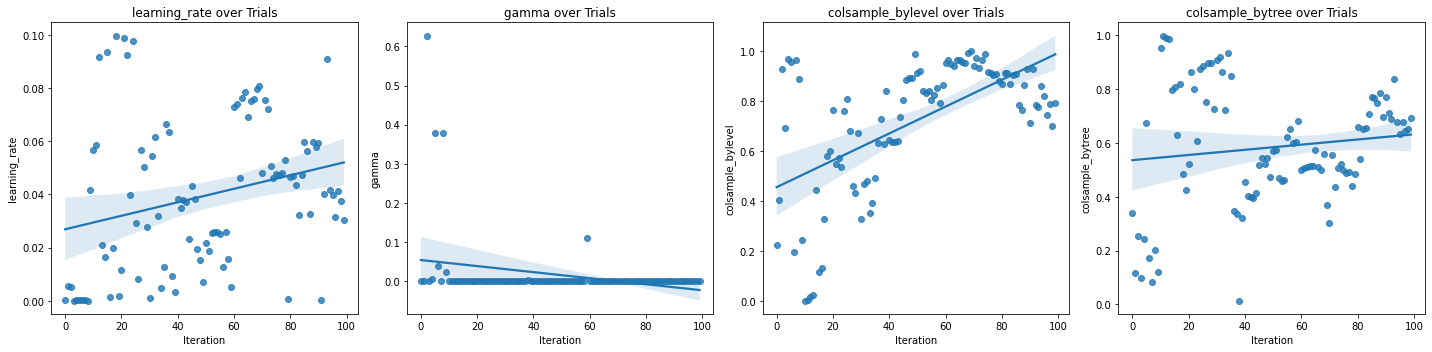

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

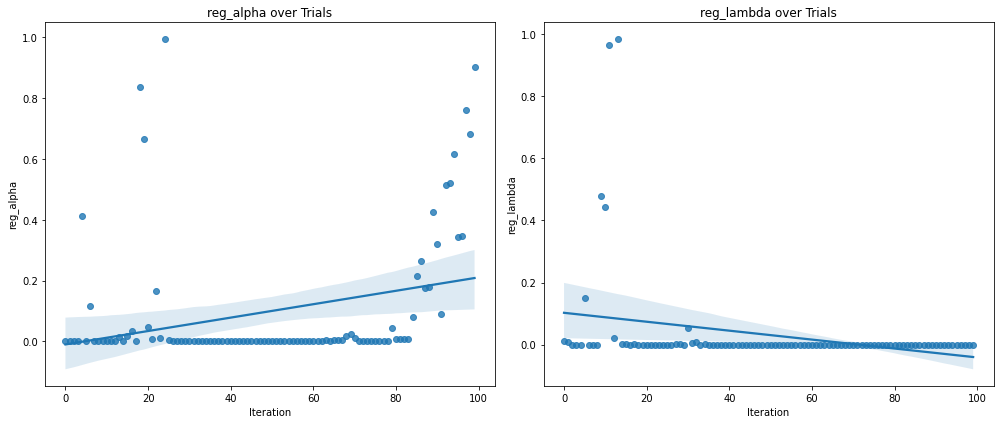

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14,6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']): 
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/XGBoost/ReviewStars/Model_Explanations/

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_XGBoost_Optuna_100_GPU.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_XGBoost_Optuna_100_GPU.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params['random_state'] = seed_value
params['loss_function']= 'Logloss'
params

{'colsample_bylevel': 0.8593051651433867,
 'colsample_bytree': 0.6771132033127644,
 'gamma': 1.6212712699815463e-08,
 'learning_rate': 0.041503794581896236,
 'loss_function': 'Logloss',
 'max_depth': 10,
 'min_child_weight': 5,
 'n_estimators': 500,
 'random_state': 42,
 'reg_alpha': 0.6166291513436883,
 'reg_lambda': 2.1440007997355195e-06,
 'subsample': 0.7091371242218932}

In [ ]:
# Set up label and features
label = df[['stars_reviews']]
features = df.cleanReview

# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, 
                                                    stratify=label)

In [ ]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [ ]:
# Re-create the best model and train on the training data
best_model = XGBClassifier(objective='binary:logistic',
                           booster='gbtree',
                           tree_method='gpu_hist',
                           scale_pos_weight=1,
                           use_label_encoder=False,
                           verbosity=0,
                           **params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'XGBoost_HPO_Optuna_trials100_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('XGBoost_HPO_Optuna_trials100_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('Results from XGBoost HPO Optuna 100 GPU trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from Xgboost HPO Optuna 100 GPU trials:


Classification Report: Train
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96    616594
         1.0       0.96      0.95      0.96    616594

    accuracy                           0.96   1233188
   macro avg       0.96      0.96      0.96   1233188
weighted avg       0.96      0.96      0.96   1233188



Confusion matrix: Train
[[590361  26233]
 [ 27983 588611]]


Classification Report: Test
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94    154149
         1.0       0.94      0.94      0.94    154149

    accuracy                           0.94    308298
   macro avg       0.94      0.94      0.94    308298
weighted avg       0.94      0.94      0.94    308298



Confusion matrix: Test
[[145004   9145]
 [  9519 144630]]


Accuracy score: train: 0.956, test: 0.939
Precision score: train: 0.957, test: 0.941
Recall score: train: 0.955, t

In [ ]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, 
                                                                                                       y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.93946 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    94
logloss                                0.153982
datetime_start       2022-04-14 15:20:14.919072
datetime_complete    2022-04-14 15:23:26.132469
duration                 0 days 00:03:11.213397
colsample_bylevel                      0.859305
colsample_bytree                       0.677113
gamma                                       0.0
learning_rate                          0.041504
max_depth                                    10
min_child_weight                              5
n_estimators                                500
reg_alpha                              0.616629
reg_lambda                             0.000002
subsample                              0.709137
state                                  COMPLETE
Name: 0, dtype: object


## GloVe 6B 50d - Reviews: 50 epochs

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

/content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models


In [ ]:
# Load model
word2vec_path = 'glove.6B.50dModel_review125_50epochs.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
wv = model.wv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



In [ ]:
print('Pipeline for Word2Vec of GloVe:')
pl  = Pipeline([('W2vVectorizer', W2vVectorizer(wv))])
pl

Pipeline for Word2Vec of GloVe:


Pipeline(steps=[('W2vVectorizer',
                 <__main__.W2vVectorizer object at 0x7f1af3f8d750>)])

### 100 Trials

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/XGBoost/ReviewStars/Model_PKL/

In [ ]:
def xgb_hpo(trial):
    """
    Objective function to tune a `XGBoostClassifier` model.
    """
    joblib.dump(study, 'XGBoost_Optuna_100_GPU_glove.pkl')

    # Define parameter grid
    params_xgboost_optuna = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=10),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_uniform('subsample', 0, 1),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0, 1),
        'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0, 1), 
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10)
        }

    # Define model
    model = XGBClassifier(
        objective='binary:logistic',
        booster='gbtree',  
        tree_method='gpu_hist', 
        scale_pos_weight=1,
        use_label_encoder=False,
        random_state=seed_value,
        verbosity=0,
        **params_xgboost_optuna)
    
    return train_model_for_study(features, label, model)

In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
if os.path.isfile('XGBoost_Optuna_100_GPU_glove.pkl'):
    study = joblib.load('XGBoost_Optuna_100_GPU_glove.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(xgb_hpo, n_trials=100)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Streaming output truncated to the last 5000 lines.
[63]	validation_0-logloss:0.18083
[64]	validation_0-logloss:0.18025
[65]	validation_0-logloss:0.17945
[66]	validation_0-logloss:0.17884
[67]	validation_0-logloss:0.17814
[68]	validation_0-logloss:0.17756
[69]	validation_0-logloss:0.17709
[70]	validation_0-logloss:0.17660
[71]	validation_0-logloss:0.17607
[72]	validation_0-logloss:0.17561
[73]	validation_0-logloss:0.17511
[74]	validation_0-logloss:0.17464
[75]	validation_0-logloss:0.17420
[76]	validation_0-logloss:0.17384
[77]	validation_0-logloss:0.17338
[78]	validation_0-logloss:0.17299
[79]	validation_0-logloss:0.17256
[80]	validation_0-logloss:0.17224
[81]	validation_0-logloss:0.17186
[82]	validation_0-logloss:0.17147
[83]	validation_0-logloss:0.17110
[84]	validation_0-logloss:0.17083
[85]	validation_0-logloss:0.17057
[86]	validation_0-logloss:0.17030
[87]	validation_0-logloss:0.17000
[88]	validation_0-logloss:0.16972
[89]	validation_0-logloss:0.16943
[90]	validation_0-logloss:0.169

[W 2022-04-15 16:47:00,494] Trial 82 failed because of the following error: OSError(107, 'Transport endpoint is not connected')
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-17-e05a88979b18>", line 43, in xgb_hpo
    return train_model_for_study(features, label, model)
  File "<ipython-input-16-840af4149783>", line 19, in train_model_for_study
    eval_set=[(X_test, y_test.values.ravel())])
  File "/usr/local/lib/python3.7/dist-packages/xgboost/core.py", line 506, in inner_f
    return f(**kwargs)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py", line 1169, in fit
    if _is_cudf_df(y) or _is_cudf_ser(y):
  File "/usr/local/lib/python3.7/dist-packages/xgboost/data.py", line 454, in _is_cudf_df
    import cudf
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 963, 

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-df9c945fc2c3>", line 9, in <module>
    study.optimize(xgb_hpo, n_trials=100)
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/study.py", line 409, in optimize
    show_progress_bar=show_progress_bar,
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 76, in _optimize
    progress_bar=progress_bar,
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 163, in _optimize_sequential
    trial = _run_trial(study, func, catch)
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 264, in _run_trial
    raise func_err
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-17-e05a88979b1

OSError: ignored

In [ ]:
# Continue training the study
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/XGBoost/ReviewStars/Model_PKL/

study = joblib.load('XGBoost_Optuna_100_GPU_glove.pkl')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

/content/drive/MyDrive/Yelp_Reviews/Models/ML/XGBoost/ReviewStars/Model_PKL
Number of finished trials: 83
Best trial: {'n_estimators': 420, 'max_depth': 8, 'subsample': 0.9419588967315974, 'gamma': 0.1325641241196812, 'learning_rate': 0.07562881283795429, 'reg_alpha': 6.517435496113269e-06, 'reg_lambda': 0.0003343142107896108, 'colsample_bytree': 0.5945036350200881, 'colsample_bylevel': 0.9453976933514601, 'min_child_weight': 2}
Lowest LogLoss 0.15577448744045325


In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
if os.path.isfile('XGBoost_Optuna_100_GPU_glove.pkl'):
    study = joblib.load('XGBoost_Optuna_100_GPU_glove.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(xgb_hpo, n_trials=17)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Streaming output truncated to the last 5000 lines.
[51]	validation_0-logloss:0.19269
[52]	validation_0-logloss:0.19164
[53]	validation_0-logloss:0.19095
[54]	validation_0-logloss:0.18959
[55]	validation_0-logloss:0.18898
[56]	validation_0-logloss:0.18818
[57]	validation_0-logloss:0.18761
[58]	validation_0-logloss:0.18651
[59]	validation_0-logloss:0.18598
[60]	validation_0-logloss:0.18512
[61]	validation_0-logloss:0.18439
[62]	validation_0-logloss:0.18354
[63]	validation_0-logloss:0.18273
[64]	validation_0-logloss:0.18190
[65]	validation_0-logloss:0.18148
[66]	validation_0-logloss:0.18066
[67]	validation_0-logloss:0.18006
[68]	validation_0-logloss:0.17954
[69]	validation_0-logloss:0.17891
[70]	validation_0-logloss:0.17824
[71]	validation_0-logloss:0.17766
[72]	validation_0-logloss:0.17716
[73]	validation_0-logloss:0.17691
[74]	validation_0-logloss:0.17652
[75]	validation_0-logloss:0.17594
[76]	validation_0-logloss:0.17554
[77]	validation_0-logloss:0.17506
[78]	validation_0-logloss:0.174

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/XGBoost/ReviewStars/trialOptions/

In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number': 'iteration'}, inplace=True)
trials_df.rename(columns={'value': 'logloss'},inplace=True)
trials_df.rename(columns={'params_colsample_bylevel': 'colsample_bylevel'}, 
                 inplace=True)
trials_df.rename(columns={'params_colsample_bytree': 'colsample_bytree'}, 
                 inplace=True)
trials_df.rename(columns={'params_gamma': 'gamma'}, inplace=True)
trials_df.rename(columns={'params_learning_rate': 'learning_rate'}, 
                 inplace=True)
trials_df.rename(columns={'params_max_depth': 'max_depth'}, inplace=True)
trials_df.rename(columns={'params_min_child_weight': 'min_child_weight'}, 
                 inplace=True)
trials_df.rename(columns={'params_n_estimators': 'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_reg_alpha': 'reg_alpha'}, inplace=True)
trials_df.rename(columns={'params_reg_lambda': 'reg_lambda'}, inplace=True)
trials_df.rename(columns={'params_subsample': 'subsample'}, inplace=True)
trials_df = trials_df.sort_values('logloss', ascending=True)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('XGBoost_Optuna_100_GPU_glove.csv', index=False)

    iteration   logloss             datetime_start          datetime_complete  \
96         96  0.155682 2022-04-15 17:35:12.040897 2022-04-15 17:38:14.812741   
73         73  0.155774 2022-04-15 16:17:29.658508 2022-04-15 16:20:26.483417   
94         94  0.155870 2022-04-15 17:29:19.381630 2022-04-15 17:32:17.697417   
97         97  0.155910 2022-04-15 17:38:14.812915 2022-04-15 17:41:17.297526   
99         99  0.155994 2022-04-15 17:44:21.686004 2022-04-15 17:47:24.454264   
..        ...       ...                        ...                        ...   
36         36  0.666497 2022-04-15 14:29:41.055974 2022-04-15 14:32:34.483388   
80         80  0.669285 2022-04-15 16:38:17.714898 2022-04-15 16:41:19.473961   
2           2  0.671845 2022-04-15 12:52:08.601312 2022-04-15 12:55:00.420086   
28         28  0.677356 2022-04-15 14:06:34.003909 2022-04-15 14:09:28.744274   
82         82       NaN 2022-04-15 16:44:15.629967                        NaT   

                 duration  

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/XGBoost/ReviewStars/Model_Explanations/

In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_XGBoost_Optuna_100_GPU_glove.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_XGBoost_Optuna_100_GPU_glove.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_XGBoost_Optuna_100_GPU_glove.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = optuna.visualization.plot_contour(study, params=['min_child_weight', 
                                                       'max_depth', 
                                                       'learning_rate', 
                                                       'gamma'])
py.plot(fig, filename='contour_XGBoost_Optuna_100_GPU_glove.html')
fig.show()

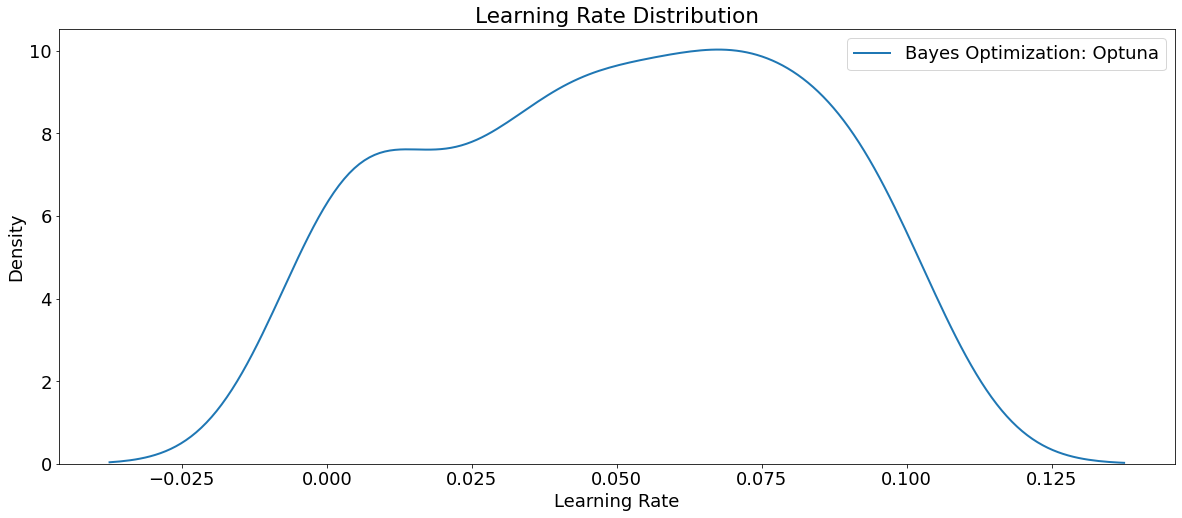

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label='Bayes Optimization: Optuna', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); 
plt.title('Learning Rate Distribution');
plt.show()

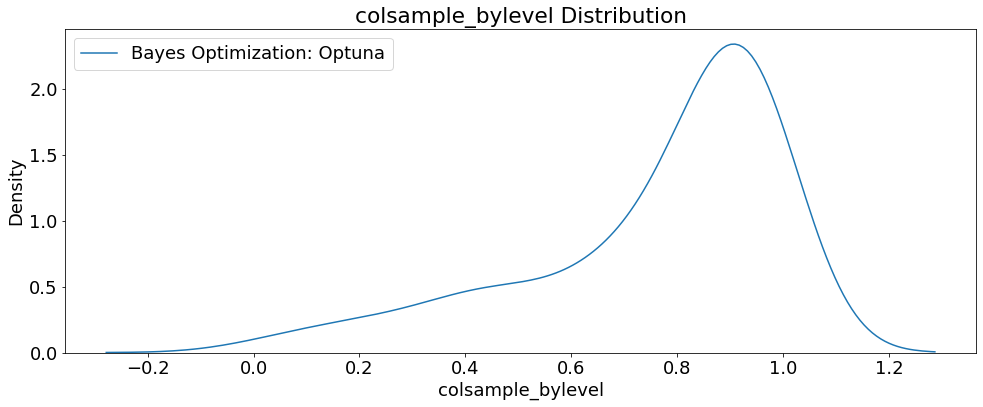

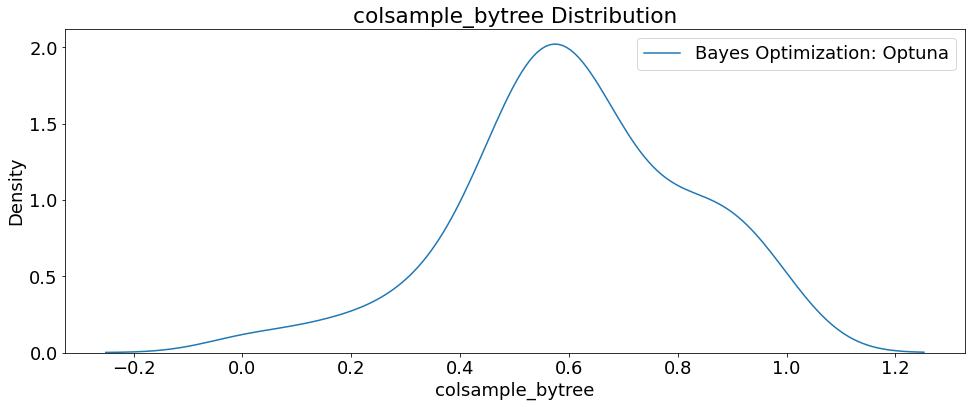

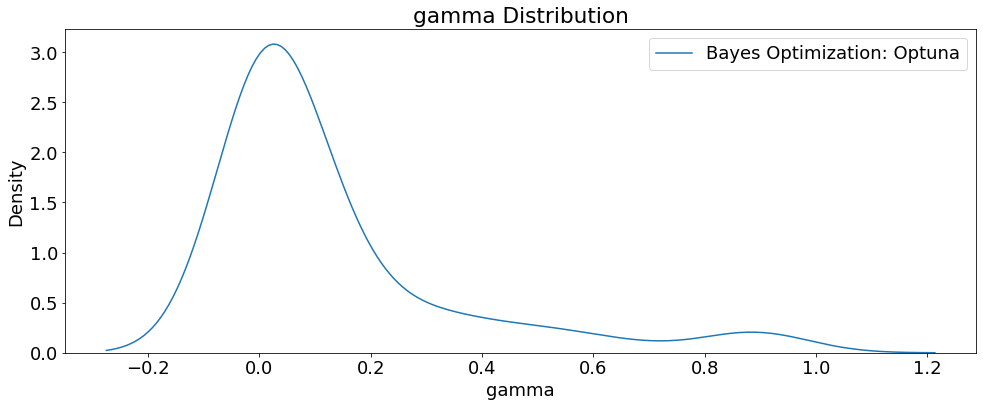

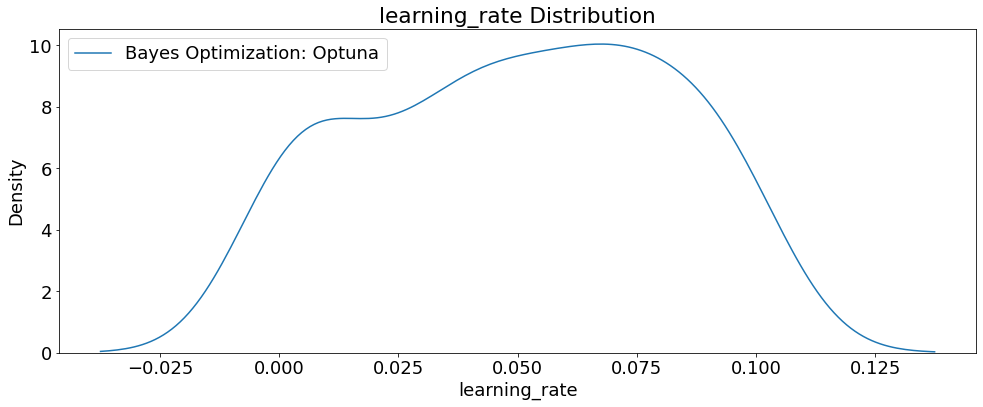

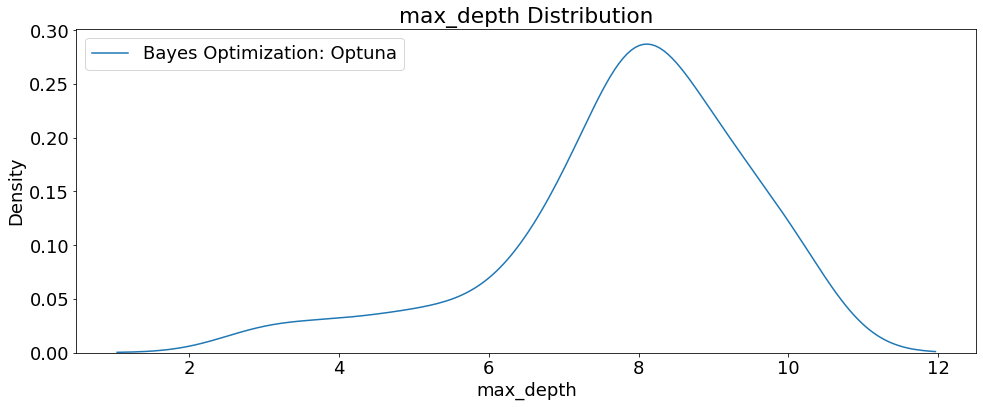

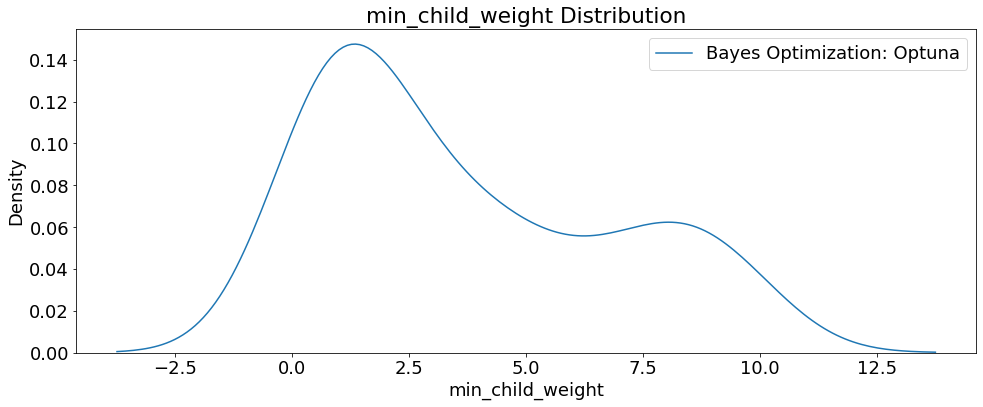

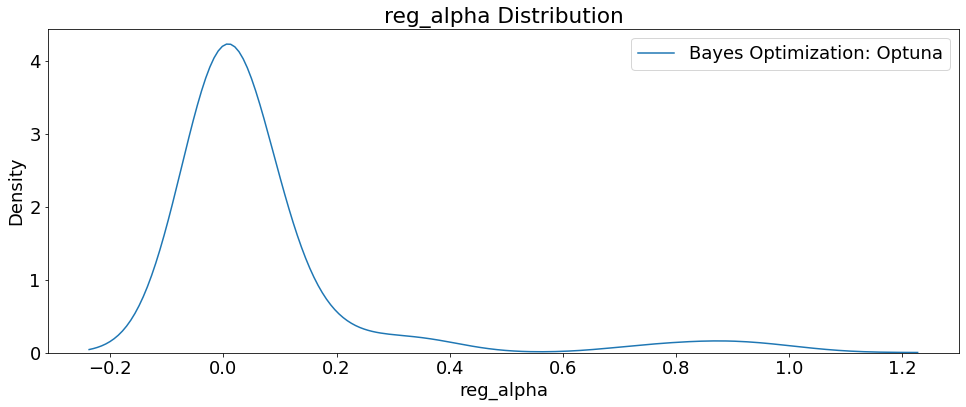

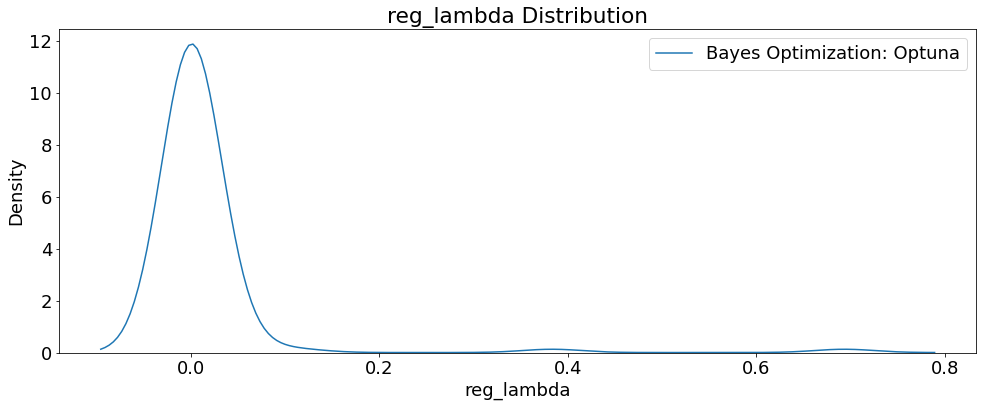

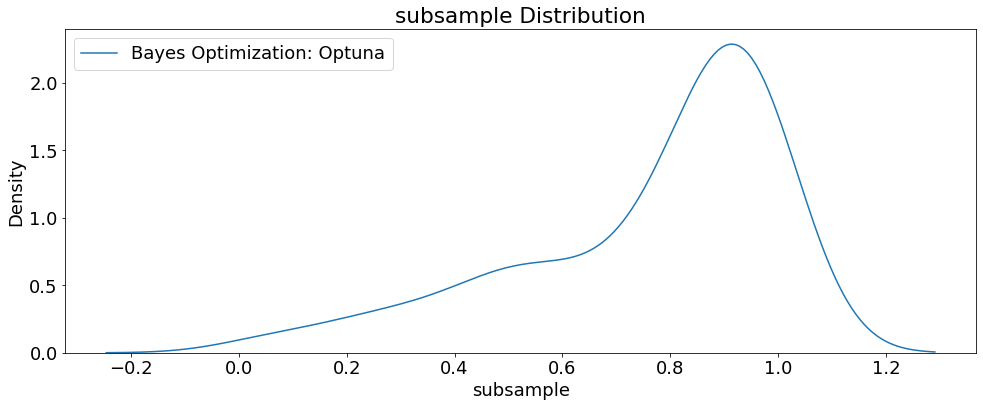

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

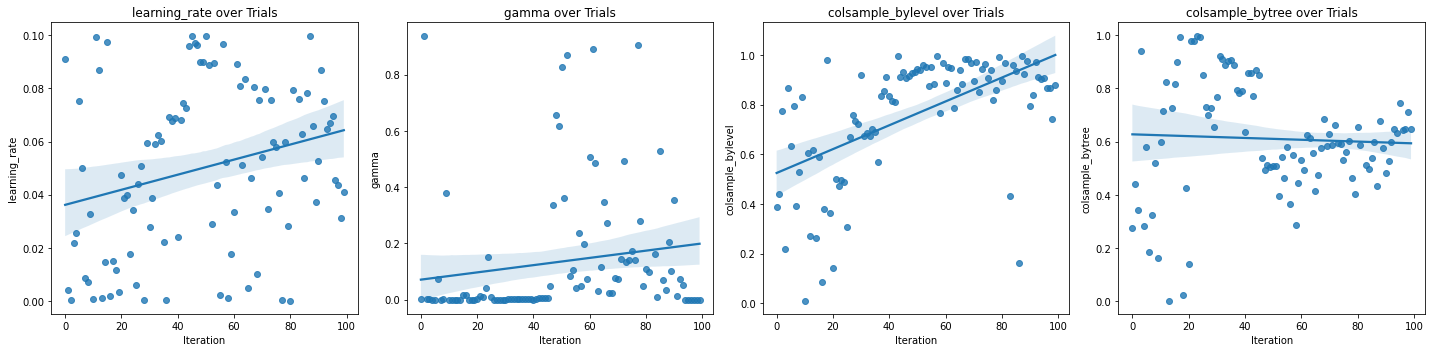

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

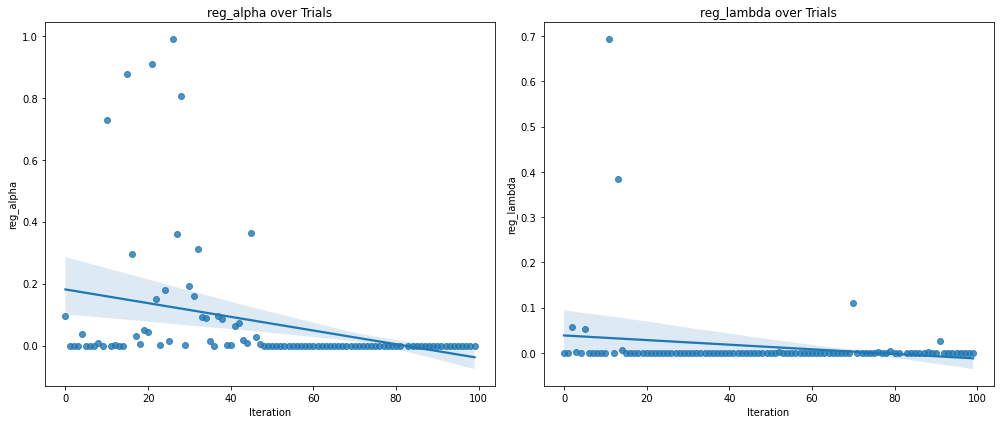

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14,6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']): 
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_XGBoost_Optuna_100_GPU_glove.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_XGBoost_Optuna_100_GPU_glove.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params['random_state'] = seed_value
params['loss_function']= 'Logloss'
params

{'colsample_bylevel': 0.8658556225641232,
 'colsample_bytree': 0.6435687156554164,
 'gamma': 1.4929524957185062e-07,
 'learning_rate': 0.04559185785030217,
 'loss_function': 'Logloss',
 'max_depth': 9,
 'min_child_weight': 4,
 'n_estimators': 420,
 'random_state': 42,
 'reg_alpha': 3.2574198366523637e-05,
 'reg_lambda': 1.1776056469365516e-07,
 'subsample': 0.8503758084259609}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/XGBoost/ReviewStars/Model_PKL/

In [ ]:
# Set up label and features
label = df[['stars_reviews']]
features = df.cleanReview

# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, 
                                                    stratify=label)

In [ ]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [ ]:
# Re-create the best model and train on the training data
best_model = XGBClassifier(objective='binary:logistic',
                           booster='gbtree',
                           tree_method='gpu_hist',
                           scale_pos_weight=1,
                           use_label_encoder=False,
                           verbosity=0,
                           **params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'XGBoost_HPO_Optuna_trials100_GPU_glove.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('XGBoost_HPO_Optuna_trials100_GPU_glove.pkl')
# print(model)
# =============================================================================

In [ ]:
print('Results from XGBoost HPO Optuna 100 GloVe GPU trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from Xgboost HPO Optuna 100 GloVe GPU trials:


Classification Report: Train
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95    616594
         1.0       0.95      0.95      0.95    616594

    accuracy                           0.95   1233188
   macro avg       0.95      0.95      0.95   1233188
weighted avg       0.95      0.95      0.95   1233188



Confusion matrix: Train
[[586743  29851]
 [ 31667 584927]]


Classification Report: Test
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94    154149
         1.0       0.94      0.94      0.94    154149

    accuracy                           0.94    308298
   macro avg       0.94      0.94      0.94    308298
weighted avg       0.94      0.94      0.94    308298



Confusion matrix: Test
[[144985   9164]
 [  9584 144565]]


Accuracy score: train: 0.950, test: 0.939
Precision score: train: 0.951, test: 0.940
Recall score: train: 0.

In [ ]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, 
                                                                                                       y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.93919 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    96
logloss                                0.155682
datetime_start       2022-04-15 17:35:12.040897
datetime_complete    2022-04-15 17:38:14.812741
duration                 0 days 00:03:02.771844
colsample_bylevel                      0.865856
colsample_bytree                       0.643569
gamma                                       0.0
learning_rate                          0.045592
max_depth                                   9.0
min_child_weight                            4.0
n_estimators                              420.0
reg_alpha                              0.000033
reg_lambda                                  0.0
subsample                              0.850376
state                                  COMPLETE
Name: 0, dtype: object


## GloVe 6B 300d - Reviews: 50 epochs

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

/content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models


In [ ]:
# Load model
word2vec_path = 'glove.6B.300dModel_review125_50epochs_balanced.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
wv = model.wv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



In [ ]:
print('Pipeline for Word2Vec of GloVe:')
pl  = Pipeline([('W2vVectorizer', W2vVectorizer(wv))])
pl

Pipeline for Word2Vec of GloVe:


Pipeline(steps=[('W2vVectorizer',
                 <__main__.W2vVectorizer object at 0x7fcbbe45f6d0>)])

### 100 Trials

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/XGBoost/ReviewStars/ReviewStars/Model_PKL/

In [ ]:
# Log in to wandb
wandb.login()

wandb_kwargs = {'project': 'YelpReviews_XGBoost_Optuna', 'entity': 'aschultz', 
                'group': 'optuna_xgb100gpu_RS_glove300d', 
                'save_code': 'False', 'notes': 'optuna_xgb100gpu_RS_glove300d'}
wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, as_multirun=True)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: ExperimentalWarning:

WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.



In [ ]:
# Set up WB callbacks
@wandbc.track_in_wandb()

def xgb_hpo(trial):
    """
    Objective function to tune a `XGBoostClassifier` model.
    """
    joblib.dump(study, 'XGBoost_Optuna_100_GPU_glove300d_balanced.pkl')

    # Define parameter grid
    params_xgboost_optuna = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=10),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_uniform('subsample', 0, 1),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0, 1),
        'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0, 1), 
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10)
        }

    # Define model
    model = XGBClassifier(
        objective='binary:logistic',
        booster='gbtree',  
        tree_method='gpu_hist', 
        scale_pos_weight=1,
        use_label_encoder=False,
        random_state=seed_value,
        verbosity=0,
        **params_xgboost_optuna)
    
    return train_model_for_study(features, label, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: ExperimentalWarning:

track_in_wandb is experimental (supported from v3.0.0). The interface can change in the future.



In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
if os.path.isfile('XGBoost_Optuna_100_GPU_glove300d_balanced.pkl'):
    study = joblib.load('XGBoost_Optuna_100_GPU_glove300d_balanced.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(xgb_hpo, n_trials=100, callbacks=[wandbc])

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)
wandb.finish()

Start Time           2022-09-06 05:37:51.258483
[0]	validation_0-logloss:0.65084
[1]	validation_0-logloss:0.61369
[2]	validation_0-logloss:0.58025
[3]	validation_0-logloss:0.55938
[4]	validation_0-logloss:0.53908
[5]	validation_0-logloss:0.52298
[6]	validation_0-logloss:0.49768
[7]	validation_0-logloss:0.48607
[8]	validation_0-logloss:0.46787
[9]	validation_0-logloss:0.45656
[10]	validation_0-logloss:0.44250
[11]	validation_0-logloss:0.42680
[12]	validation_0-logloss:0.41602
[13]	validation_0-logloss:0.40267
[14]	validation_0-logloss:0.38982
[15]	validation_0-logloss:0.37919
[16]	validation_0-logloss:0.37098
[17]	validation_0-logloss:0.36161
[18]	validation_0-logloss:0.35575
[19]	validation_0-logloss:0.34483
[20]	validation_0-logloss:0.33678
[21]	validation_0-logloss:0.33016
[22]	validation_0-logloss:0.32362
[23]	validation_0-logloss:0.31776
[24]	validation_0-logloss:0.31080
[25]	validation_0-logloss:0.30700
[26]	validation_0-logloss:0.30252
[27]	validation_0-logloss:0.29708
[28]	valid

[0]	validation_0-logloss:0.66491
[1]	validation_0-logloss:0.65322
[2]	validation_0-logloss:0.63115
[3]	validation_0-logloss:0.62274
[4]	validation_0-logloss:0.59571
[5]	validation_0-logloss:0.58295
[6]	validation_0-logloss:0.56386
[7]	validation_0-logloss:0.54764
[8]	validation_0-logloss:0.53890
[9]	validation_0-logloss:0.52240
[10]	validation_0-logloss:0.50738
[11]	validation_0-logloss:0.49464
[12]	validation_0-logloss:0.47913
[13]	validation_0-logloss:0.47014
[14]	validation_0-logloss:0.45504
[15]	validation_0-logloss:0.44770
[16]	validation_0-logloss:0.43643
[17]	validation_0-logloss:0.42873
[18]	validation_0-logloss:0.41937
[19]	validation_0-logloss:0.41480
[20]	validation_0-logloss:0.40423
[21]	validation_0-logloss:0.39888
[22]	validation_0-logloss:0.39003
[23]	validation_0-logloss:0.38037
[24]	validation_0-logloss:0.37316
[25]	validation_0-logloss:0.36450
[26]	validation_0-logloss:0.36097
[27]	validation_0-logloss:0.35512
[28]	validation_0-logloss:0.34793
[29]	validation_0-loglos

[0]	validation_0-logloss:0.68171
[1]	validation_0-logloss:0.67008
[2]	validation_0-logloss:0.65872
[3]	validation_0-logloss:0.64716
[4]	validation_0-logloss:0.63648
[5]	validation_0-logloss:0.62923
[6]	validation_0-logloss:0.61919
[7]	validation_0-logloss:0.61190
[8]	validation_0-logloss:0.60239
[9]	validation_0-logloss:0.59393
[10]	validation_0-logloss:0.58472
[11]	validation_0-logloss:0.57627
[12]	validation_0-logloss:0.56911
[13]	validation_0-logloss:0.56180
[14]	validation_0-logloss:0.55438
[15]	validation_0-logloss:0.54678
[16]	validation_0-logloss:0.53997
[17]	validation_0-logloss:0.53249
[18]	validation_0-logloss:0.52775
[19]	validation_0-logloss:0.52085
[20]	validation_0-logloss:0.51456
[21]	validation_0-logloss:0.50848
[22]	validation_0-logloss:0.50210
[23]	validation_0-logloss:0.49620
[24]	validation_0-logloss:0.49007
[25]	validation_0-logloss:0.48495
[26]	validation_0-logloss:0.47998
[27]	validation_0-logloss:0.47403
[28]	validation_0-logloss:0.46800
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66814
[1]	validation_0-logloss:0.64991
[2]	validation_0-logloss:0.64034
[3]	validation_0-logloss:0.63148
[4]	validation_0-logloss:0.61670
[5]	validation_0-logloss:0.60227
[6]	validation_0-logloss:0.59164
[7]	validation_0-logloss:0.57131
[8]	validation_0-logloss:0.55394
[9]	validation_0-logloss:0.54848
[10]	validation_0-logloss:0.53379
[11]	validation_0-logloss:0.51921
[12]	validation_0-logloss:0.50468
[13]	validation_0-logloss:0.49881
[14]	validation_0-logloss:0.49151
[15]	validation_0-logloss:0.47725
[16]	validation_0-logloss:0.46655
[17]	validation_0-logloss:0.45899
[18]	validation_0-logloss:0.44859
[19]	validation_0-logloss:0.44326
[20]	validation_0-logloss:0.43647
[21]	validation_0-logloss:0.43044
[22]	validation_0-logloss:0.42616
[23]	validation_0-logloss:0.42031
[24]	validation_0-logloss:0.41005
[25]	validation_0-logloss:0.40475
[26]	validation_0-logloss:0.39724
[27]	validation_0-logloss:0.39347
[28]	validation_0-logloss:0.38454
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66348
[1]	validation_0-logloss:0.64659
[2]	validation_0-logloss:0.61071
[3]	validation_0-logloss:0.58450
[4]	validation_0-logloss:0.55314
[5]	validation_0-logloss:0.53475
[6]	validation_0-logloss:0.51782
[7]	validation_0-logloss:0.49649
[8]	validation_0-logloss:0.48784
[9]	validation_0-logloss:0.46789
[10]	validation_0-logloss:0.45578
[11]	validation_0-logloss:0.44952
[12]	validation_0-logloss:0.44181
[13]	validation_0-logloss:0.43198
[14]	validation_0-logloss:0.42520
[15]	validation_0-logloss:0.41634
[16]	validation_0-logloss:0.40885
[17]	validation_0-logloss:0.40060
[18]	validation_0-logloss:0.38890
[19]	validation_0-logloss:0.38546
[20]	validation_0-logloss:0.38018
[21]	validation_0-logloss:0.37222
[22]	validation_0-logloss:0.36417
[23]	validation_0-logloss:0.35576
[24]	validation_0-logloss:0.34985
[25]	validation_0-logloss:0.34119
[26]	validation_0-logloss:0.33772
[27]	validation_0-logloss:0.33348
[28]	validation_0-logloss:0.32474
[29]	validation_0-loglos

[0]	validation_0-logloss:0.69216
[1]	validation_0-logloss:0.68016
[2]	validation_0-logloss:0.67693
[3]	validation_0-logloss:0.66970
[4]	validation_0-logloss:0.66747
[5]	validation_0-logloss:0.64890
[6]	validation_0-logloss:0.64690
[7]	validation_0-logloss:0.64081
[8]	validation_0-logloss:0.63732
[9]	validation_0-logloss:0.63560
[10]	validation_0-logloss:0.63485
[11]	validation_0-logloss:0.63338
[12]	validation_0-logloss:0.63046
[13]	validation_0-logloss:0.62534
[14]	validation_0-logloss:0.61576
[15]	validation_0-logloss:0.60747
[16]	validation_0-logloss:0.59355
[17]	validation_0-logloss:0.59115
[18]	validation_0-logloss:0.57672
[19]	validation_0-logloss:0.57540
[20]	validation_0-logloss:0.57501
[21]	validation_0-logloss:0.57072
[22]	validation_0-logloss:0.55961
[23]	validation_0-logloss:0.55502
[24]	validation_0-logloss:0.53598
[25]	validation_0-logloss:0.53057
[26]	validation_0-logloss:0.53036
[27]	validation_0-logloss:0.52452
[28]	validation_0-logloss:0.52223
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65245
[1]	validation_0-logloss:0.61045
[2]	validation_0-logloss:0.58167
[3]	validation_0-logloss:0.55197
[4]	validation_0-logloss:0.52910
[5]	validation_0-logloss:0.50354
[6]	validation_0-logloss:0.48419
[7]	validation_0-logloss:0.47244
[8]	validation_0-logloss:0.45730
[9]	validation_0-logloss:0.44389
[10]	validation_0-logloss:0.42800
[11]	validation_0-logloss:0.41888
[12]	validation_0-logloss:0.40919
[13]	validation_0-logloss:0.39673
[14]	validation_0-logloss:0.38956
[15]	validation_0-logloss:0.37794
[16]	validation_0-logloss:0.36984
[17]	validation_0-logloss:0.36036
[18]	validation_0-logloss:0.35232
[19]	validation_0-logloss:0.34666
[20]	validation_0-logloss:0.34309
[21]	validation_0-logloss:0.33804
[22]	validation_0-logloss:0.33106
[23]	validation_0-logloss:0.32439
[24]	validation_0-logloss:0.31884
[25]	validation_0-logloss:0.31602
[26]	validation_0-logloss:0.31127
[27]	validation_0-logloss:0.30941
[28]	validation_0-logloss:0.30607
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65746
[1]	validation_0-logloss:0.63091
[2]	validation_0-logloss:0.59816
[3]	validation_0-logloss:0.57836
[4]	validation_0-logloss:0.55923
[5]	validation_0-logloss:0.54453
[6]	validation_0-logloss:0.53100
[7]	validation_0-logloss:0.51664
[8]	validation_0-logloss:0.50226
[9]	validation_0-logloss:0.48643
[10]	validation_0-logloss:0.47033
[11]	validation_0-logloss:0.45535
[12]	validation_0-logloss:0.44816
[13]	validation_0-logloss:0.43555
[14]	validation_0-logloss:0.42724
[15]	validation_0-logloss:0.41677
[16]	validation_0-logloss:0.40449
[17]	validation_0-logloss:0.39576
[18]	validation_0-logloss:0.38602
[19]	validation_0-logloss:0.38236
[20]	validation_0-logloss:0.37412
[21]	validation_0-logloss:0.36506
[22]	validation_0-logloss:0.36176
[23]	validation_0-logloss:0.35491
[24]	validation_0-logloss:0.34980
[25]	validation_0-logloss:0.34725
[26]	validation_0-logloss:0.34333
[27]	validation_0-logloss:0.33924
[28]	validation_0-logloss:0.33421
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65264
[1]	validation_0-logloss:0.61627
[2]	validation_0-logloss:0.58469
[3]	validation_0-logloss:0.55783
[4]	validation_0-logloss:0.52973
[5]	validation_0-logloss:0.50498
[6]	validation_0-logloss:0.48455
[7]	validation_0-logloss:0.46518
[8]	validation_0-logloss:0.44502
[9]	validation_0-logloss:0.43116
[10]	validation_0-logloss:0.41516
[11]	validation_0-logloss:0.40073
[12]	validation_0-logloss:0.38606
[13]	validation_0-logloss:0.37317
[14]	validation_0-logloss:0.36288
[15]	validation_0-logloss:0.35133
[16]	validation_0-logloss:0.34018
[17]	validation_0-logloss:0.33253
[18]	validation_0-logloss:0.32336
[19]	validation_0-logloss:0.31586
[20]	validation_0-logloss:0.30924
[21]	validation_0-logloss:0.30106
[22]	validation_0-logloss:0.29368
[23]	validation_0-logloss:0.28742
[24]	validation_0-logloss:0.28130
[25]	validation_0-logloss:0.27518
[26]	validation_0-logloss:0.26946
[27]	validation_0-logloss:0.26403
[28]	validation_0-logloss:0.25929
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65462
[1]	validation_0-logloss:0.62409
[2]	validation_0-logloss:0.59857
[3]	validation_0-logloss:0.57326
[4]	validation_0-logloss:0.54474
[5]	validation_0-logloss:0.52089
[6]	validation_0-logloss:0.50115
[7]	validation_0-logloss:0.48367
[8]	validation_0-logloss:0.46475
[9]	validation_0-logloss:0.45205
[10]	validation_0-logloss:0.44340
[11]	validation_0-logloss:0.42917
[12]	validation_0-logloss:0.41614
[13]	validation_0-logloss:0.40823
[14]	validation_0-logloss:0.40381
[15]	validation_0-logloss:0.39144
[16]	validation_0-logloss:0.37805
[17]	validation_0-logloss:0.37167
[18]	validation_0-logloss:0.36316
[19]	validation_0-logloss:0.35647
[20]	validation_0-logloss:0.35368
[21]	validation_0-logloss:0.34312
[22]	validation_0-logloss:0.33851
[23]	validation_0-logloss:0.33454
[24]	validation_0-logloss:0.32874
[25]	validation_0-logloss:0.32255
[26]	validation_0-logloss:0.31629
[27]	validation_0-logloss:0.30824
[28]	validation_0-logloss:0.30269
[29]	validation_0-loglos

[0]	validation_0-logloss:0.68058
[1]	validation_0-logloss:0.66851
[2]	validation_0-logloss:0.65706
[3]	validation_0-logloss:0.64615
[4]	validation_0-logloss:0.63577
[5]	validation_0-logloss:0.62573
[6]	validation_0-logloss:0.61795
[7]	validation_0-logloss:0.60862
[8]	validation_0-logloss:0.59958
[9]	validation_0-logloss:0.59093
[10]	validation_0-logloss:0.58366
[11]	validation_0-logloss:0.57595
[12]	validation_0-logloss:0.56903
[13]	validation_0-logloss:0.56315
[14]	validation_0-logloss:0.55709
[15]	validation_0-logloss:0.54986
[16]	validation_0-logloss:0.54290
[17]	validation_0-logloss:0.53597
[18]	validation_0-logloss:0.53076
[19]	validation_0-logloss:0.52477
[20]	validation_0-logloss:0.51935
[21]	validation_0-logloss:0.51340
[22]	validation_0-logloss:0.50755
[23]	validation_0-logloss:0.50214
[24]	validation_0-logloss:0.49722
[25]	validation_0-logloss:0.49196
[26]	validation_0-logloss:0.48664
[27]	validation_0-logloss:0.48197
[28]	validation_0-logloss:0.47737
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66410
[1]	validation_0-logloss:0.63599
[2]	validation_0-logloss:0.61055
[3]	validation_0-logloss:0.58640
[4]	validation_0-logloss:0.56426
[5]	validation_0-logloss:0.54508
[6]	validation_0-logloss:0.52709
[7]	validation_0-logloss:0.51013
[8]	validation_0-logloss:0.49418
[9]	validation_0-logloss:0.47811
[10]	validation_0-logloss:0.46580
[11]	validation_0-logloss:0.45173
[12]	validation_0-logloss:0.43876
[13]	validation_0-logloss:0.42718
[14]	validation_0-logloss:0.41558
[15]	validation_0-logloss:0.40426
[16]	validation_0-logloss:0.39375
[17]	validation_0-logloss:0.38356
[18]	validation_0-logloss:0.37443
[19]	validation_0-logloss:0.36559
[20]	validation_0-logloss:0.35689
[21]	validation_0-logloss:0.34904
[22]	validation_0-logloss:0.34150
[23]	validation_0-logloss:0.33423
[24]	validation_0-logloss:0.32734
[25]	validation_0-logloss:0.32061
[26]	validation_0-logloss:0.31445
[27]	validation_0-logloss:0.30841
[28]	validation_0-logloss:0.30263
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66827
[1]	validation_0-logloss:0.64474
[2]	validation_0-logloss:0.62246
[3]	validation_0-logloss:0.60271
[4]	validation_0-logloss:0.58301
[5]	validation_0-logloss:0.56458
[6]	validation_0-logloss:0.54774
[7]	validation_0-logloss:0.53148
[8]	validation_0-logloss:0.51606
[9]	validation_0-logloss:0.50145
[10]	validation_0-logloss:0.48838
[11]	validation_0-logloss:0.47545
[12]	validation_0-logloss:0.46306
[13]	validation_0-logloss:0.45141
[14]	validation_0-logloss:0.44013
[15]	validation_0-logloss:0.42968
[16]	validation_0-logloss:0.41999
[17]	validation_0-logloss:0.41039
[18]	validation_0-logloss:0.40096
[19]	validation_0-logloss:0.39240
[20]	validation_0-logloss:0.38396
[21]	validation_0-logloss:0.37609
[22]	validation_0-logloss:0.36846
[23]	validation_0-logloss:0.36107
[24]	validation_0-logloss:0.35398
[25]	validation_0-logloss:0.34742
[26]	validation_0-logloss:0.34098
[27]	validation_0-logloss:0.33496
[28]	validation_0-logloss:0.32913
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66127
[1]	validation_0-logloss:0.63269
[2]	validation_0-logloss:0.60560
[3]	validation_0-logloss:0.58099
[4]	validation_0-logloss:0.56039
[5]	validation_0-logloss:0.53823
[6]	validation_0-logloss:0.51744
[7]	validation_0-logloss:0.49874
[8]	validation_0-logloss:0.48323
[9]	validation_0-logloss:0.46688
[10]	validation_0-logloss:0.45168
[11]	validation_0-logloss:0.43945
[12]	validation_0-logloss:0.42684
[13]	validation_0-logloss:0.41482
[14]	validation_0-logloss:0.40257
[15]	validation_0-logloss:0.39190
[16]	validation_0-logloss:0.38106
[17]	validation_0-logloss:0.37120
[18]	validation_0-logloss:0.36176
[19]	validation_0-logloss:0.35327
[20]	validation_0-logloss:0.34514
[21]	validation_0-logloss:0.33765
[22]	validation_0-logloss:0.33027
[23]	validation_0-logloss:0.32395
[24]	validation_0-logloss:0.31723
[25]	validation_0-logloss:0.31075
[26]	validation_0-logloss:0.30502
[27]	validation_0-logloss:0.29907
[28]	validation_0-logloss:0.29418
[29]	validation_0-loglos

[0]	validation_0-logloss:0.69064
[1]	validation_0-logloss:0.68814
[2]	validation_0-logloss:0.68563
[3]	validation_0-logloss:0.68326
[4]	validation_0-logloss:0.68078
[5]	validation_0-logloss:0.67836
[6]	validation_0-logloss:0.67597
[7]	validation_0-logloss:0.67362
[8]	validation_0-logloss:0.67121
[9]	validation_0-logloss:0.66885
[10]	validation_0-logloss:0.66659
[11]	validation_0-logloss:0.66424
[12]	validation_0-logloss:0.66206
[13]	validation_0-logloss:0.65978
[14]	validation_0-logloss:0.65755
[15]	validation_0-logloss:0.65528
[16]	validation_0-logloss:0.65309
[17]	validation_0-logloss:0.65086
[18]	validation_0-logloss:0.64865
[19]	validation_0-logloss:0.64648
[20]	validation_0-logloss:0.64426
[21]	validation_0-logloss:0.64206
[22]	validation_0-logloss:0.63995
[23]	validation_0-logloss:0.63779
[24]	validation_0-logloss:0.63567
[25]	validation_0-logloss:0.63353
[26]	validation_0-logloss:0.63147
[27]	validation_0-logloss:0.62946
[28]	validation_0-logloss:0.62735
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65728
[1]	validation_0-logloss:0.62486
[2]	validation_0-logloss:0.59764
[3]	validation_0-logloss:0.57422
[4]	validation_0-logloss:0.54851
[5]	validation_0-logloss:0.52568
[6]	validation_0-logloss:0.50717
[7]	validation_0-logloss:0.49042
[8]	validation_0-logloss:0.47090
[9]	validation_0-logloss:0.45755
[10]	validation_0-logloss:0.44243
[11]	validation_0-logloss:0.42916
[12]	validation_0-logloss:0.41505
[13]	validation_0-logloss:0.40243
[14]	validation_0-logloss:0.39307
[15]	validation_0-logloss:0.38086
[16]	validation_0-logloss:0.37004
[17]	validation_0-logloss:0.36310
[18]	validation_0-logloss:0.35360
[19]	validation_0-logloss:0.34712
[20]	validation_0-logloss:0.34052
[21]	validation_0-logloss:0.33160
[22]	validation_0-logloss:0.32555
[23]	validation_0-logloss:0.31858
[24]	validation_0-logloss:0.31157
[25]	validation_0-logloss:0.30469
[26]	validation_0-logloss:0.29855
[27]	validation_0-logloss:0.29266
[28]	validation_0-logloss:0.28723
[29]	validation_0-loglos

[0]	validation_0-logloss:0.68586
[1]	validation_0-logloss:0.66470
[2]	validation_0-logloss:0.65262
[3]	validation_0-logloss:0.64477
[4]	validation_0-logloss:0.62780
[5]	validation_0-logloss:0.61842
[6]	validation_0-logloss:0.60427
[7]	validation_0-logloss:0.59121
[8]	validation_0-logloss:0.57626
[9]	validation_0-logloss:0.56576
[10]	validation_0-logloss:0.55578
[11]	validation_0-logloss:0.53773
[12]	validation_0-logloss:0.52051
[13]	validation_0-logloss:0.50665
[14]	validation_0-logloss:0.50355
[15]	validation_0-logloss:0.50199
[16]	validation_0-logloss:0.49113
[17]	validation_0-logloss:0.48451
[18]	validation_0-logloss:0.47477
[19]	validation_0-logloss:0.47178
[20]	validation_0-logloss:0.46412
[21]	validation_0-logloss:0.46044
[22]	validation_0-logloss:0.45448
[23]	validation_0-logloss:0.44351
[24]	validation_0-logloss:0.43392
[25]	validation_0-logloss:0.42627
[26]	validation_0-logloss:0.42013
[27]	validation_0-logloss:0.41646
[28]	validation_0-logloss:0.41110
[29]	validation_0-loglos

[0]	validation_0-logloss:0.67126
[1]	validation_0-logloss:0.65060
[2]	validation_0-logloss:0.63206
[3]	validation_0-logloss:0.61560
[4]	validation_0-logloss:0.59733
[5]	validation_0-logloss:0.58098
[6]	validation_0-logloss:0.56687
[7]	validation_0-logloss:0.55342
[8]	validation_0-logloss:0.53827
[9]	validation_0-logloss:0.52767
[10]	validation_0-logloss:0.51481
[11]	validation_0-logloss:0.50440
[12]	validation_0-logloss:0.49172
[13]	validation_0-logloss:0.48023
[14]	validation_0-logloss:0.47113
[15]	validation_0-logloss:0.46034
[16]	validation_0-logloss:0.45001
[17]	validation_0-logloss:0.44430
[18]	validation_0-logloss:0.43503
[19]	validation_0-logloss:0.42736
[20]	validation_0-logloss:0.42015
[21]	validation_0-logloss:0.41134
[22]	validation_0-logloss:0.40483
[23]	validation_0-logloss:0.39771
[24]	validation_0-logloss:0.39032
[25]	validation_0-logloss:0.38282
[26]	validation_0-logloss:0.37594
[27]	validation_0-logloss:0.36927
[28]	validation_0-logloss:0.36328
[29]	validation_0-loglos

[0]	validation_0-logloss:0.69227
[1]	validation_0-logloss:0.68162
[2]	validation_0-logloss:0.67878
[3]	validation_0-logloss:0.67233
[4]	validation_0-logloss:0.67036
[5]	validation_0-logloss:0.65380
[6]	validation_0-logloss:0.65199
[7]	validation_0-logloss:0.64647
[8]	validation_0-logloss:0.64335
[9]	validation_0-logloss:0.64181
[10]	validation_0-logloss:0.64112
[11]	validation_0-logloss:0.63980
[12]	validation_0-logloss:0.63714
[13]	validation_0-logloss:0.63248
[14]	validation_0-logloss:0.62376
[15]	validation_0-logloss:0.61607
[16]	validation_0-logloss:0.60325
[17]	validation_0-logloss:0.60106
[18]	validation_0-logloss:0.58775
[19]	validation_0-logloss:0.58653
[20]	validation_0-logloss:0.58617
[21]	validation_0-logloss:0.58213
[22]	validation_0-logloss:0.57164
[23]	validation_0-logloss:0.56744
[24]	validation_0-logloss:0.54971
[25]	validation_0-logloss:0.54465
[26]	validation_0-logloss:0.54443
[27]	validation_0-logloss:0.53881
[28]	validation_0-logloss:0.53679
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66027
[1]	validation_0-logloss:0.62829
[2]	validation_0-logloss:0.60198
[3]	validation_0-logloss:0.57973
[4]	validation_0-logloss:0.55236
[5]	validation_0-logloss:0.53039
[6]	validation_0-logloss:0.51076
[7]	validation_0-logloss:0.49200
[8]	validation_0-logloss:0.47406
[9]	validation_0-logloss:0.46048
[10]	validation_0-logloss:0.44502
[11]	validation_0-logloss:0.43055
[12]	validation_0-logloss:0.41657
[13]	validation_0-logloss:0.40304
[14]	validation_0-logloss:0.39371
[15]	validation_0-logloss:0.38210
[16]	validation_0-logloss:0.37076
[17]	validation_0-logloss:0.36416
[18]	validation_0-logloss:0.35505
[19]	validation_0-logloss:0.34715
[20]	validation_0-logloss:0.34096
[21]	validation_0-logloss:0.33248
[22]	validation_0-logloss:0.32599
[23]	validation_0-logloss:0.32025
[24]	validation_0-logloss:0.31393
[25]	validation_0-logloss:0.30697
[26]	validation_0-logloss:0.30144
[27]	validation_0-logloss:0.29469
[28]	validation_0-logloss:0.28990
[29]	validation_0-loglos

[0]	validation_0-logloss:0.67285
[1]	validation_0-logloss:0.65689
[2]	validation_0-logloss:0.63876
[3]	validation_0-logloss:0.62946
[4]	validation_0-logloss:0.61971
[5]	validation_0-logloss:0.60585
[6]	validation_0-logloss:0.59434
[7]	validation_0-logloss:0.57942
[8]	validation_0-logloss:0.56350
[9]	validation_0-logloss:0.55413
[10]	validation_0-logloss:0.54465
[11]	validation_0-logloss:0.53178
[12]	validation_0-logloss:0.51829
[13]	validation_0-logloss:0.51091
[14]	validation_0-logloss:0.49917
[15]	validation_0-logloss:0.48954
[16]	validation_0-logloss:0.48186
[17]	validation_0-logloss:0.47092
[18]	validation_0-logloss:0.46395
[19]	validation_0-logloss:0.45795
[20]	validation_0-logloss:0.45026
[21]	validation_0-logloss:0.44263
[22]	validation_0-logloss:0.43417
[23]	validation_0-logloss:0.42933
[24]	validation_0-logloss:0.42200
[25]	validation_0-logloss:0.41559
[26]	validation_0-logloss:0.41020
[27]	validation_0-logloss:0.40374
[28]	validation_0-logloss:0.39710
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66056
[1]	validation_0-logloss:0.63126
[2]	validation_0-logloss:0.60373
[3]	validation_0-logloss:0.57879
[4]	validation_0-logloss:0.55787
[5]	validation_0-logloss:0.53537
[6]	validation_0-logloss:0.51425
[7]	validation_0-logloss:0.49535
[8]	validation_0-logloss:0.47920
[9]	validation_0-logloss:0.46274
[10]	validation_0-logloss:0.44741
[11]	validation_0-logloss:0.43458
[12]	validation_0-logloss:0.42198
[13]	validation_0-logloss:0.40992
[14]	validation_0-logloss:0.39761
[15]	validation_0-logloss:0.38687
[16]	validation_0-logloss:0.37605
[17]	validation_0-logloss:0.36615
[18]	validation_0-logloss:0.35680
[19]	validation_0-logloss:0.34812
[20]	validation_0-logloss:0.34011
[21]	validation_0-logloss:0.33272
[22]	validation_0-logloss:0.32539
[23]	validation_0-logloss:0.31910
[24]	validation_0-logloss:0.31231
[25]	validation_0-logloss:0.30595
[26]	validation_0-logloss:0.30029
[27]	validation_0-logloss:0.29440
[28]	validation_0-logloss:0.28955
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66516
[1]	validation_0-logloss:0.63996
[2]	validation_0-logloss:0.61826
[3]	validation_0-logloss:0.59982
[4]	validation_0-logloss:0.57996
[5]	validation_0-logloss:0.56193
[6]	validation_0-logloss:0.54416
[7]	validation_0-logloss:0.52628
[8]	validation_0-logloss:0.51156
[9]	validation_0-logloss:0.49572
[10]	validation_0-logloss:0.48057
[11]	validation_0-logloss:0.46667
[12]	validation_0-logloss:0.45396
[13]	validation_0-logloss:0.44129
[14]	validation_0-logloss:0.42972
[15]	validation_0-logloss:0.41923
[16]	validation_0-logloss:0.40917
[17]	validation_0-logloss:0.39909
[18]	validation_0-logloss:0.39179
[19]	validation_0-logloss:0.38379
[20]	validation_0-logloss:0.37493
[21]	validation_0-logloss:0.36701
[22]	validation_0-logloss:0.35923
[23]	validation_0-logloss:0.35169
[24]	validation_0-logloss:0.34490
[25]	validation_0-logloss:0.33836
[26]	validation_0-logloss:0.33200
[27]	validation_0-logloss:0.32666
[28]	validation_0-logloss:0.32053
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65674
[1]	validation_0-logloss:0.62348
[2]	validation_0-logloss:0.59335
[3]	validation_0-logloss:0.56546
[4]	validation_0-logloss:0.54101
[5]	validation_0-logloss:0.51733
[6]	validation_0-logloss:0.49584
[7]	validation_0-logloss:0.47659
[8]	validation_0-logloss:0.46035
[9]	validation_0-logloss:0.44375
[10]	validation_0-logloss:0.42884
[11]	validation_0-logloss:0.41401
[12]	validation_0-logloss:0.40010
[13]	validation_0-logloss:0.38847
[14]	validation_0-logloss:0.37886
[15]	validation_0-logloss:0.36828
[16]	validation_0-logloss:0.35725
[17]	validation_0-logloss:0.34759
[18]	validation_0-logloss:0.33931
[19]	validation_0-logloss:0.33001
[20]	validation_0-logloss:0.32166
[21]	validation_0-logloss:0.31450
[22]	validation_0-logloss:0.30707
[23]	validation_0-logloss:0.30025
[24]	validation_0-logloss:0.29378
[25]	validation_0-logloss:0.28735
[26]	validation_0-logloss:0.28171
[27]	validation_0-logloss:0.27654
[28]	validation_0-logloss:0.27112
[29]	validation_0-loglos

[0]	validation_0-logloss:0.64697
[1]	validation_0-logloss:0.60573
[2]	validation_0-logloss:0.56921
[3]	validation_0-logloss:0.53798
[4]	validation_0-logloss:0.50847
[5]	validation_0-logloss:0.48236
[6]	validation_0-logloss:0.45941
[7]	validation_0-logloss:0.43857
[8]	validation_0-logloss:0.41877
[9]	validation_0-logloss:0.40106
[10]	validation_0-logloss:0.38538
[11]	validation_0-logloss:0.37038
[12]	validation_0-logloss:0.35666
[13]	validation_0-logloss:0.34432
[14]	validation_0-logloss:0.33268
[15]	validation_0-logloss:0.32204
[16]	validation_0-logloss:0.31211
[17]	validation_0-logloss:0.30292
[18]	validation_0-logloss:0.29437
[19]	validation_0-logloss:0.28670
[20]	validation_0-logloss:0.27934
[21]	validation_0-logloss:0.27260
[22]	validation_0-logloss:0.26648
[23]	validation_0-logloss:0.26042
[24]	validation_0-logloss:0.25505
[25]	validation_0-logloss:0.25002
[26]	validation_0-logloss:0.24503
[27]	validation_0-logloss:0.24082
[28]	validation_0-logloss:0.23663
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65983
[1]	validation_0-logloss:0.63053
[2]	validation_0-logloss:0.60474
[3]	validation_0-logloss:0.58147
[4]	validation_0-logloss:0.56068
[5]	validation_0-logloss:0.54176
[6]	validation_0-logloss:0.52461
[7]	validation_0-logloss:0.50937
[8]	validation_0-logloss:0.49670
[9]	validation_0-logloss:0.48311
[10]	validation_0-logloss:0.47026
[11]	validation_0-logloss:0.45855
[12]	validation_0-logloss:0.44797
[13]	validation_0-logloss:0.43752
[14]	validation_0-logloss:0.42815
[15]	validation_0-logloss:0.41932
[16]	validation_0-logloss:0.41129
[17]	validation_0-logloss:0.40378
[18]	validation_0-logloss:0.39625
[19]	validation_0-logloss:0.38885
[20]	validation_0-logloss:0.38219
[21]	validation_0-logloss:0.37608
[22]	validation_0-logloss:0.36958
[23]	validation_0-logloss:0.36414
[24]	validation_0-logloss:0.35848
[25]	validation_0-logloss:0.35318
[26]	validation_0-logloss:0.34744
[27]	validation_0-logloss:0.34268
[28]	validation_0-logloss:0.33823
[29]	validation_0-loglos

[0]	validation_0-logloss:0.64249
[1]	validation_0-logloss:0.59829
[2]	validation_0-logloss:0.56062
[3]	validation_0-logloss:0.52719
[4]	validation_0-logloss:0.49672
[5]	validation_0-logloss:0.46953
[6]	validation_0-logloss:0.44538
[7]	validation_0-logloss:0.42389
[8]	validation_0-logloss:0.40419
[9]	validation_0-logloss:0.38633
[10]	validation_0-logloss:0.37038
[11]	validation_0-logloss:0.35580
[12]	validation_0-logloss:0.34215
[13]	validation_0-logloss:0.32983
[14]	validation_0-logloss:0.31857
[15]	validation_0-logloss:0.30860
[16]	validation_0-logloss:0.29927
[17]	validation_0-logloss:0.29091
[18]	validation_0-logloss:0.28286
[19]	validation_0-logloss:0.27564
[20]	validation_0-logloss:0.26880
[21]	validation_0-logloss:0.26247
[22]	validation_0-logloss:0.25666
[23]	validation_0-logloss:0.25136
[24]	validation_0-logloss:0.24618
[25]	validation_0-logloss:0.24146
[26]	validation_0-logloss:0.23710
[27]	validation_0-logloss:0.23273
[28]	validation_0-logloss:0.22892
[29]	validation_0-loglos

[0]	validation_0-logloss:0.64546
[1]	validation_0-logloss:0.60772
[2]	validation_0-logloss:0.57048
[3]	validation_0-logloss:0.54163
[4]	validation_0-logloss:0.51326
[5]	validation_0-logloss:0.48631
[6]	validation_0-logloss:0.46223
[7]	validation_0-logloss:0.44056
[8]	validation_0-logloss:0.42105
[9]	validation_0-logloss:0.40564
[10]	validation_0-logloss:0.38999
[11]	validation_0-logloss:0.37838
[12]	validation_0-logloss:0.36732
[13]	validation_0-logloss:0.35365
[14]	validation_0-logloss:0.34165
[15]	validation_0-logloss:0.33165
[16]	validation_0-logloss:0.32084
[17]	validation_0-logloss:0.31156
[18]	validation_0-logloss:0.30255
[19]	validation_0-logloss:0.29472
[20]	validation_0-logloss:0.28745
[21]	validation_0-logloss:0.28075
[22]	validation_0-logloss:0.27474
[23]	validation_0-logloss:0.26879
[24]	validation_0-logloss:0.26445
[25]	validation_0-logloss:0.26018
[26]	validation_0-logloss:0.25510
[27]	validation_0-logloss:0.25055
[28]	validation_0-logloss:0.24619
[29]	validation_0-loglos

[0]	validation_0-logloss:0.63369
[1]	validation_0-logloss:0.58367
[2]	validation_0-logloss:0.54057
[3]	validation_0-logloss:0.50340
[4]	validation_0-logloss:0.47167
[5]	validation_0-logloss:0.44313
[6]	validation_0-logloss:0.41825
[7]	validation_0-logloss:0.39574
[8]	validation_0-logloss:0.37609
[9]	validation_0-logloss:0.35840
[10]	validation_0-logloss:0.34194
[11]	validation_0-logloss:0.32776
[12]	validation_0-logloss:0.31503
[13]	validation_0-logloss:0.30370
[14]	validation_0-logloss:0.29304
[15]	validation_0-logloss:0.28372
[16]	validation_0-logloss:0.27525
[17]	validation_0-logloss:0.26790
[18]	validation_0-logloss:0.26018
[19]	validation_0-logloss:0.25339
[20]	validation_0-logloss:0.24739
[21]	validation_0-logloss:0.24180
[22]	validation_0-logloss:0.23649
[23]	validation_0-logloss:0.23161
[24]	validation_0-logloss:0.22748
[25]	validation_0-logloss:0.22318
[26]	validation_0-logloss:0.21920
[27]	validation_0-logloss:0.21582
[28]	validation_0-logloss:0.21279
[29]	validation_0-loglos

[0]	validation_0-logloss:0.64675
[1]	validation_0-logloss:0.60054
[2]	validation_0-logloss:0.56663
[3]	validation_0-logloss:0.53149
[4]	validation_0-logloss:0.50425
[5]	validation_0-logloss:0.47850
[6]	validation_0-logloss:0.45854
[7]	validation_0-logloss:0.44110
[8]	validation_0-logloss:0.42267
[9]	validation_0-logloss:0.40814
[10]	validation_0-logloss:0.39007
[11]	validation_0-logloss:0.37917
[12]	validation_0-logloss:0.36586
[13]	validation_0-logloss:0.35233
[14]	validation_0-logloss:0.33978
[15]	validation_0-logloss:0.32896
[16]	validation_0-logloss:0.31825
[17]	validation_0-logloss:0.30930
[18]	validation_0-logloss:0.30049
[19]	validation_0-logloss:0.29459
[20]	validation_0-logloss:0.28871
[21]	validation_0-logloss:0.28240
[22]	validation_0-logloss:0.27638
[23]	validation_0-logloss:0.26999
[24]	validation_0-logloss:0.26429
[25]	validation_0-logloss:0.25962
[26]	validation_0-logloss:0.25528
[27]	validation_0-logloss:0.25250
[28]	validation_0-logloss:0.24878
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65610
[1]	validation_0-logloss:0.62871
[2]	validation_0-logloss:0.59742
[3]	validation_0-logloss:0.57647
[4]	validation_0-logloss:0.55166
[5]	validation_0-logloss:0.53151
[6]	validation_0-logloss:0.51040
[7]	validation_0-logloss:0.49223
[8]	validation_0-logloss:0.47561
[9]	validation_0-logloss:0.45898
[10]	validation_0-logloss:0.44522
[11]	validation_0-logloss:0.43246
[12]	validation_0-logloss:0.41938
[13]	validation_0-logloss:0.40873
[14]	validation_0-logloss:0.39905
[15]	validation_0-logloss:0.38886
[16]	validation_0-logloss:0.37969
[17]	validation_0-logloss:0.37148
[18]	validation_0-logloss:0.36307
[19]	validation_0-logloss:0.35523
[20]	validation_0-logloss:0.34861
[21]	validation_0-logloss:0.34259
[22]	validation_0-logloss:0.33605
[23]	validation_0-logloss:0.33080
[24]	validation_0-logloss:0.32538
[25]	validation_0-logloss:0.32006
[26]	validation_0-logloss:0.31493
[27]	validation_0-logloss:0.31054
[28]	validation_0-logloss:0.30576
[29]	validation_0-loglos

[0]	validation_0-logloss:0.64859
[1]	validation_0-logloss:0.60941
[2]	validation_0-logloss:0.57408
[3]	validation_0-logloss:0.54391
[4]	validation_0-logloss:0.51536
[5]	validation_0-logloss:0.48969
[6]	validation_0-logloss:0.46682
[7]	validation_0-logloss:0.44579
[8]	validation_0-logloss:0.42633
[9]	validation_0-logloss:0.40854
[10]	validation_0-logloss:0.39304
[11]	validation_0-logloss:0.37812
[12]	validation_0-logloss:0.36416
[13]	validation_0-logloss:0.35180
[14]	validation_0-logloss:0.34011
[15]	validation_0-logloss:0.32967
[16]	validation_0-logloss:0.31970
[17]	validation_0-logloss:0.31048
[18]	validation_0-logloss:0.30175
[19]	validation_0-logloss:0.29397
[20]	validation_0-logloss:0.28653
[21]	validation_0-logloss:0.27969
[22]	validation_0-logloss:0.27309
[23]	validation_0-logloss:0.26692
[24]	validation_0-logloss:0.26122
[25]	validation_0-logloss:0.25610
[26]	validation_0-logloss:0.25098
[27]	validation_0-logloss:0.24639
[28]	validation_0-logloss:0.24199
[29]	validation_0-loglos

[0]	validation_0-logloss:0.64977
[1]	validation_0-logloss:0.61150
[2]	validation_0-logloss:0.57712
[3]	validation_0-logloss:0.54625
[4]	validation_0-logloss:0.51936
[5]	validation_0-logloss:0.49427
[6]	validation_0-logloss:0.47158
[7]	validation_0-logloss:0.45049
[8]	validation_0-logloss:0.43148
[9]	validation_0-logloss:0.41425
[10]	validation_0-logloss:0.39801
[11]	validation_0-logloss:0.38339
[12]	validation_0-logloss:0.36997
[13]	validation_0-logloss:0.35771
[14]	validation_0-logloss:0.34609
[15]	validation_0-logloss:0.33554
[16]	validation_0-logloss:0.32580
[17]	validation_0-logloss:0.31716
[18]	validation_0-logloss:0.30833
[19]	validation_0-logloss:0.30041
[20]	validation_0-logloss:0.29315
[21]	validation_0-logloss:0.28618
[22]	validation_0-logloss:0.27951
[23]	validation_0-logloss:0.27339
[24]	validation_0-logloss:0.26786
[25]	validation_0-logloss:0.26238
[26]	validation_0-logloss:0.25721
[27]	validation_0-logloss:0.25268
[28]	validation_0-logloss:0.24842
[29]	validation_0-loglos

[0]	validation_0-logloss:0.64282
[1]	validation_0-logloss:0.60323
[2]	validation_0-logloss:0.56458
[3]	validation_0-logloss:0.52930
[4]	validation_0-logloss:0.50530
[5]	validation_0-logloss:0.47681
[6]	validation_0-logloss:0.45261
[7]	validation_0-logloss:0.43084
[8]	validation_0-logloss:0.41086
[9]	validation_0-logloss:0.39490
[10]	validation_0-logloss:0.37994
[11]	validation_0-logloss:0.36397
[12]	validation_0-logloss:0.35015
[13]	validation_0-logloss:0.33846
[14]	validation_0-logloss:0.32882
[15]	validation_0-logloss:0.31781
[16]	validation_0-logloss:0.31147
[17]	validation_0-logloss:0.30230
[18]	validation_0-logloss:0.29389
[19]	validation_0-logloss:0.28617
[20]	validation_0-logloss:0.27913
[21]	validation_0-logloss:0.27260
[22]	validation_0-logloss:0.26664
[23]	validation_0-logloss:0.26166
[24]	validation_0-logloss:0.25599
[25]	validation_0-logloss:0.25123
[26]	validation_0-logloss:0.24680
[27]	validation_0-logloss:0.24240
[28]	validation_0-logloss:0.23810
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65609
[1]	validation_0-logloss:0.62255
[2]	validation_0-logloss:0.59214
[3]	validation_0-logloss:0.56562
[4]	validation_0-logloss:0.53999
[5]	validation_0-logloss:0.51695
[6]	validation_0-logloss:0.49612
[7]	validation_0-logloss:0.47691
[8]	validation_0-logloss:0.45832
[9]	validation_0-logloss:0.44144
[10]	validation_0-logloss:0.42609
[11]	validation_0-logloss:0.41151
[12]	validation_0-logloss:0.39788
[13]	validation_0-logloss:0.38531
[14]	validation_0-logloss:0.37346
[15]	validation_0-logloss:0.36241
[16]	validation_0-logloss:0.35207
[17]	validation_0-logloss:0.34236
[18]	validation_0-logloss:0.33331
[19]	validation_0-logloss:0.32489
[20]	validation_0-logloss:0.31685
[21]	validation_0-logloss:0.30938
[22]	validation_0-logloss:0.30238
[23]	validation_0-logloss:0.29560
[24]	validation_0-logloss:0.28930
[25]	validation_0-logloss:0.28343
[26]	validation_0-logloss:0.27758
[27]	validation_0-logloss:0.27252
[28]	validation_0-logloss:0.26751
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65579
[1]	validation_0-logloss:0.62197
[2]	validation_0-logloss:0.59187
[3]	validation_0-logloss:0.56421
[4]	validation_0-logloss:0.53876
[5]	validation_0-logloss:0.51589
[6]	validation_0-logloss:0.49456
[7]	validation_0-logloss:0.47506
[8]	validation_0-logloss:0.45700
[9]	validation_0-logloss:0.44012
[10]	validation_0-logloss:0.42502
[11]	validation_0-logloss:0.41039
[12]	validation_0-logloss:0.39675
[13]	validation_0-logloss:0.38460
[14]	validation_0-logloss:0.37259
[15]	validation_0-logloss:0.36125
[16]	validation_0-logloss:0.35088
[17]	validation_0-logloss:0.34108
[18]	validation_0-logloss:0.33216
[19]	validation_0-logloss:0.32390
[20]	validation_0-logloss:0.31583
[21]	validation_0-logloss:0.30810
[22]	validation_0-logloss:0.30128
[23]	validation_0-logloss:0.29467
[24]	validation_0-logloss:0.28839
[25]	validation_0-logloss:0.28248
[26]	validation_0-logloss:0.27693
[27]	validation_0-logloss:0.27178
[28]	validation_0-logloss:0.26674
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65584
[1]	validation_0-logloss:0.62204
[2]	validation_0-logloss:0.59201
[3]	validation_0-logloss:0.56437
[4]	validation_0-logloss:0.53898
[5]	validation_0-logloss:0.51610
[6]	validation_0-logloss:0.49476
[7]	validation_0-logloss:0.47530
[8]	validation_0-logloss:0.45722
[9]	validation_0-logloss:0.44022
[10]	validation_0-logloss:0.42513
[11]	validation_0-logloss:0.41046
[12]	validation_0-logloss:0.39690
[13]	validation_0-logloss:0.38478
[14]	validation_0-logloss:0.37271
[15]	validation_0-logloss:0.36137
[16]	validation_0-logloss:0.35107
[17]	validation_0-logloss:0.34128
[18]	validation_0-logloss:0.33235
[19]	validation_0-logloss:0.32418
[20]	validation_0-logloss:0.31607
[21]	validation_0-logloss:0.30832
[22]	validation_0-logloss:0.30148
[23]	validation_0-logloss:0.29487
[24]	validation_0-logloss:0.28858
[25]	validation_0-logloss:0.28269
[26]	validation_0-logloss:0.27715
[27]	validation_0-logloss:0.27193
[28]	validation_0-logloss:0.26689
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65739
[1]	validation_0-logloss:0.62513
[2]	validation_0-logloss:0.59543
[3]	validation_0-logloss:0.56832
[4]	validation_0-logloss:0.54377
[5]	validation_0-logloss:0.52091
[6]	validation_0-logloss:0.49978
[7]	validation_0-logloss:0.48030
[8]	validation_0-logloss:0.46303
[9]	validation_0-logloss:0.44652
[10]	validation_0-logloss:0.43135
[11]	validation_0-logloss:0.41678
[12]	validation_0-logloss:0.40330
[13]	validation_0-logloss:0.39039
[14]	validation_0-logloss:0.37866
[15]	validation_0-logloss:0.36765
[16]	validation_0-logloss:0.35742
[17]	validation_0-logloss:0.34778
[18]	validation_0-logloss:0.33871
[19]	validation_0-logloss:0.33018
[20]	validation_0-logloss:0.32216
[21]	validation_0-logloss:0.31460
[22]	validation_0-logloss:0.30751
[23]	validation_0-logloss:0.30083
[24]	validation_0-logloss:0.29454
[25]	validation_0-logloss:0.28822
[26]	validation_0-logloss:0.28260
[27]	validation_0-logloss:0.27738
[28]	validation_0-logloss:0.27229
[29]	validation_0-loglos

[0]	validation_0-logloss:0.67293
[1]	validation_0-logloss:0.65385
[2]	validation_0-logloss:0.63556
[3]	validation_0-logloss:0.61825
[4]	validation_0-logloss:0.60210
[5]	validation_0-logloss:0.58644
[6]	validation_0-logloss:0.57152
[7]	validation_0-logloss:0.55731
[8]	validation_0-logloss:0.54431
[9]	validation_0-logloss:0.53149
[10]	validation_0-logloss:0.51934
[11]	validation_0-logloss:0.50747
[12]	validation_0-logloss:0.49615
[13]	validation_0-logloss:0.48527
[14]	validation_0-logloss:0.47485
[15]	validation_0-logloss:0.46494
[16]	validation_0-logloss:0.45553
[17]	validation_0-logloss:0.44644
[18]	validation_0-logloss:0.43763
[19]	validation_0-logloss:0.42920
[20]	validation_0-logloss:0.42111
[21]	validation_0-logloss:0.41327
[22]	validation_0-logloss:0.40576
[23]	validation_0-logloss:0.39853
[24]	validation_0-logloss:0.39155
[25]	validation_0-logloss:0.38472
[26]	validation_0-logloss:0.37826
[27]	validation_0-logloss:0.37217
[28]	validation_0-logloss:0.36614
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65670
[1]	validation_0-logloss:0.62352
[2]	validation_0-logloss:0.59401
[3]	validation_0-logloss:0.56680
[4]	validation_0-logloss:0.54177
[5]	validation_0-logloss:0.51920
[6]	validation_0-logloss:0.49807
[7]	validation_0-logloss:0.47880
[8]	validation_0-logloss:0.46085
[9]	validation_0-logloss:0.44401
[10]	validation_0-logloss:0.42899
[11]	validation_0-logloss:0.41440
[12]	validation_0-logloss:0.40079
[13]	validation_0-logloss:0.38867
[14]	validation_0-logloss:0.37660
[15]	validation_0-logloss:0.36525
[16]	validation_0-logloss:0.35489
[17]	validation_0-logloss:0.34506
[18]	validation_0-logloss:0.33611
[19]	validation_0-logloss:0.32783
[20]	validation_0-logloss:0.31967
[21]	validation_0-logloss:0.31187
[22]	validation_0-logloss:0.30496
[23]	validation_0-logloss:0.29826
[24]	validation_0-logloss:0.29187
[25]	validation_0-logloss:0.28589
[26]	validation_0-logloss:0.28027
[27]	validation_0-logloss:0.27501
[28]	validation_0-logloss:0.26991
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66194
[1]	validation_0-logloss:0.63316
[2]	validation_0-logloss:0.60716
[3]	validation_0-logloss:0.58291
[4]	validation_0-logloss:0.56029
[5]	validation_0-logloss:0.53976
[6]	validation_0-logloss:0.52033
[7]	validation_0-logloss:0.50235
[8]	validation_0-logloss:0.48551
[9]	validation_0-logloss:0.46948
[10]	validation_0-logloss:0.45523
[11]	validation_0-logloss:0.44121
[12]	validation_0-logloss:0.42800
[13]	validation_0-logloss:0.41617
[14]	validation_0-logloss:0.40442
[15]	validation_0-logloss:0.39313
[16]	validation_0-logloss:0.38274
[17]	validation_0-logloss:0.37281
[18]	validation_0-logloss:0.36376
[19]	validation_0-logloss:0.35530
[20]	validation_0-logloss:0.34688
[21]	validation_0-logloss:0.33884
[22]	validation_0-logloss:0.33158
[23]	validation_0-logloss:0.32455
[24]	validation_0-logloss:0.31782
[25]	validation_0-logloss:0.31146
[26]	validation_0-logloss:0.30547
[27]	validation_0-logloss:0.29973
[28]	validation_0-logloss:0.29420
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66280
[1]	validation_0-logloss:0.63474
[2]	validation_0-logloss:0.60932
[3]	validation_0-logloss:0.58558
[4]	validation_0-logloss:0.56341
[5]	validation_0-logloss:0.54324
[6]	validation_0-logloss:0.52408
[7]	validation_0-logloss:0.50630
[8]	validation_0-logloss:0.48966
[9]	validation_0-logloss:0.47386
[10]	validation_0-logloss:0.45975
[11]	validation_0-logloss:0.44583
[12]	validation_0-logloss:0.43259
[13]	validation_0-logloss:0.42086
[14]	validation_0-logloss:0.40911
[15]	validation_0-logloss:0.39787
[16]	validation_0-logloss:0.38749
[17]	validation_0-logloss:0.37758
[18]	validation_0-logloss:0.36852
[19]	validation_0-logloss:0.35997
[20]	validation_0-logloss:0.35152
[21]	validation_0-logloss:0.34347
[22]	validation_0-logloss:0.33617
[23]	validation_0-logloss:0.32909
[24]	validation_0-logloss:0.32232
[25]	validation_0-logloss:0.31592
[26]	validation_0-logloss:0.30986
[27]	validation_0-logloss:0.30401
[28]	validation_0-logloss:0.29836
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65537
[1]	validation_0-logloss:0.62093
[2]	validation_0-logloss:0.59042
[3]	validation_0-logloss:0.56238
[4]	validation_0-logloss:0.53655
[5]	validation_0-logloss:0.51334
[6]	validation_0-logloss:0.49179
[7]	validation_0-logloss:0.47214
[8]	validation_0-logloss:0.45392
[9]	validation_0-logloss:0.43688
[10]	validation_0-logloss:0.42169
[11]	validation_0-logloss:0.40696
[12]	validation_0-logloss:0.39325
[13]	validation_0-logloss:0.38106
[14]	validation_0-logloss:0.36901
[15]	validation_0-logloss:0.35768
[16]	validation_0-logloss:0.34735
[17]	validation_0-logloss:0.33752
[18]	validation_0-logloss:0.32866
[19]	validation_0-logloss:0.32053
[20]	validation_0-logloss:0.31247
[21]	validation_0-logloss:0.30477
[22]	validation_0-logloss:0.29795
[23]	validation_0-logloss:0.29136
[24]	validation_0-logloss:0.28516
[25]	validation_0-logloss:0.27930
[26]	validation_0-logloss:0.27381
[27]	validation_0-logloss:0.26868
[28]	validation_0-logloss:0.26365
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66263
[1]	validation_0-logloss:0.63319
[2]	validation_0-logloss:0.60667
[3]	validation_0-logloss:0.58188
[4]	validation_0-logloss:0.55916
[5]	validation_0-logloss:0.53918
[6]	validation_0-logloss:0.51958
[7]	validation_0-logloss:0.50204
[8]	validation_0-logloss:0.48578
[9]	validation_0-logloss:0.46946
[10]	validation_0-logloss:0.45689
[11]	validation_0-logloss:0.44237
[12]	validation_0-logloss:0.42918
[13]	validation_0-logloss:0.41714
[14]	validation_0-logloss:0.40511
[15]	validation_0-logloss:0.39386
[16]	validation_0-logloss:0.38326
[17]	validation_0-logloss:0.37296
[18]	validation_0-logloss:0.36373
[19]	validation_0-logloss:0.35499
[20]	validation_0-logloss:0.34638
[21]	validation_0-logloss:0.33850
[22]	validation_0-logloss:0.33106
[23]	validation_0-logloss:0.32386
[24]	validation_0-logloss:0.31709
[25]	validation_0-logloss:0.31053
[26]	validation_0-logloss:0.30448
[27]	validation_0-logloss:0.29862
[28]	validation_0-logloss:0.29291
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66705
[1]	validation_0-logloss:0.64167
[2]	validation_0-logloss:0.61872
[3]	validation_0-logloss:0.59670
[4]	validation_0-logloss:0.57648
[5]	validation_0-logloss:0.55801
[6]	validation_0-logloss:0.54108
[7]	validation_0-logloss:0.52578
[8]	validation_0-logloss:0.50999
[9]	validation_0-logloss:0.49561
[10]	validation_0-logloss:0.48156
[11]	validation_0-logloss:0.46862
[12]	validation_0-logloss:0.45647
[13]	validation_0-logloss:0.44467
[14]	validation_0-logloss:0.43397
[15]	validation_0-logloss:0.42324
[16]	validation_0-logloss:0.41296
[17]	validation_0-logloss:0.40323
[18]	validation_0-logloss:0.39590
[19]	validation_0-logloss:0.38696
[20]	validation_0-logloss:0.37870
[21]	validation_0-logloss:0.37105
[22]	validation_0-logloss:0.36361
[23]	validation_0-logloss:0.35676
[24]	validation_0-logloss:0.35008
[25]	validation_0-logloss:0.34443
[26]	validation_0-logloss:0.33805
[27]	validation_0-logloss:0.33195
[28]	validation_0-logloss:0.32608
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65666
[1]	validation_0-logloss:0.62327
[2]	validation_0-logloss:0.59356
[3]	validation_0-logloss:0.56615
[4]	validation_0-logloss:0.54084
[5]	validation_0-logloss:0.51807
[6]	validation_0-logloss:0.49690
[7]	validation_0-logloss:0.47750
[8]	validation_0-logloss:0.45951
[9]	validation_0-logloss:0.44252
[10]	validation_0-logloss:0.42746
[11]	validation_0-logloss:0.41287
[12]	validation_0-logloss:0.39920
[13]	validation_0-logloss:0.38705
[14]	validation_0-logloss:0.37501
[15]	validation_0-logloss:0.36361
[16]	validation_0-logloss:0.35324
[17]	validation_0-logloss:0.34334
[18]	validation_0-logloss:0.33437
[19]	validation_0-logloss:0.32612
[20]	validation_0-logloss:0.31798
[21]	validation_0-logloss:0.31017
[22]	validation_0-logloss:0.30323
[23]	validation_0-logloss:0.29651
[24]	validation_0-logloss:0.29018
[25]	validation_0-logloss:0.28420
[26]	validation_0-logloss:0.27864
[27]	validation_0-logloss:0.27336
[28]	validation_0-logloss:0.26825
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65746
[1]	validation_0-logloss:0.62575
[2]	validation_0-logloss:0.59724
[3]	validation_0-logloss:0.57093
[4]	validation_0-logloss:0.54626
[5]	validation_0-logloss:0.52411
[6]	validation_0-logloss:0.50290
[7]	validation_0-logloss:0.48407
[8]	validation_0-logloss:0.46631
[9]	validation_0-logloss:0.44946
[10]	validation_0-logloss:0.43386
[11]	validation_0-logloss:0.41985
[12]	validation_0-logloss:0.40650
[13]	validation_0-logloss:0.39410
[14]	validation_0-logloss:0.38223
[15]	validation_0-logloss:0.37200
[16]	validation_0-logloss:0.36162
[17]	validation_0-logloss:0.35222
[18]	validation_0-logloss:0.34315
[19]	validation_0-logloss:0.33467
[20]	validation_0-logloss:0.32687
[21]	validation_0-logloss:0.31912
[22]	validation_0-logloss:0.31195
[23]	validation_0-logloss:0.30537
[24]	validation_0-logloss:0.29895
[25]	validation_0-logloss:0.29282
[26]	validation_0-logloss:0.28694
[27]	validation_0-logloss:0.28146
[28]	validation_0-logloss:0.27618
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65831
[1]	validation_0-logloss:0.62730
[2]	validation_0-logloss:0.59923
[3]	validation_0-logloss:0.57336
[4]	validation_0-logloss:0.54902
[5]	validation_0-logloss:0.52723
[6]	validation_0-logloss:0.50628
[7]	validation_0-logloss:0.48765
[8]	validation_0-logloss:0.46999
[9]	validation_0-logloss:0.45326
[10]	validation_0-logloss:0.43769
[11]	validation_0-logloss:0.42371
[12]	validation_0-logloss:0.41052
[13]	validation_0-logloss:0.39821
[14]	validation_0-logloss:0.38635
[15]	validation_0-logloss:0.37611
[16]	validation_0-logloss:0.36572
[17]	validation_0-logloss:0.35625
[18]	validation_0-logloss:0.34716
[19]	validation_0-logloss:0.33865
[20]	validation_0-logloss:0.33082
[21]	validation_0-logloss:0.32303
[22]	validation_0-logloss:0.31580
[23]	validation_0-logloss:0.30915
[24]	validation_0-logloss:0.30269
[25]	validation_0-logloss:0.29649
[26]	validation_0-logloss:0.29054
[27]	validation_0-logloss:0.28500
[28]	validation_0-logloss:0.27966
[29]	validation_0-loglos

[0]	validation_0-logloss:0.68266
[1]	validation_0-logloss:0.67239
[2]	validation_0-logloss:0.66273
[3]	validation_0-logloss:0.65332
[4]	validation_0-logloss:0.64404
[5]	validation_0-logloss:0.63486
[6]	validation_0-logloss:0.62591
[7]	validation_0-logloss:0.61733
[8]	validation_0-logloss:0.60881
[9]	validation_0-logloss:0.60057
[10]	validation_0-logloss:0.59251
[11]	validation_0-logloss:0.58470
[12]	validation_0-logloss:0.57729
[13]	validation_0-logloss:0.57009
[14]	validation_0-logloss:0.56282
[15]	validation_0-logloss:0.55607
[16]	validation_0-logloss:0.54919
[17]	validation_0-logloss:0.54260
[18]	validation_0-logloss:0.53611
[19]	validation_0-logloss:0.52982
[20]	validation_0-logloss:0.52353
[21]	validation_0-logloss:0.51736
[22]	validation_0-logloss:0.51142
[23]	validation_0-logloss:0.50572
[24]	validation_0-logloss:0.50008
[25]	validation_0-logloss:0.49443
[26]	validation_0-logloss:0.48889
[27]	validation_0-logloss:0.48353
[28]	validation_0-logloss:0.47832
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66107
[1]	validation_0-logloss:0.63207
[2]	validation_0-logloss:0.60500
[3]	validation_0-logloss:0.58762
[4]	validation_0-logloss:0.57044
[5]	validation_0-logloss:0.55636
[6]	validation_0-logloss:0.53466
[7]	validation_0-logloss:0.52439
[8]	validation_0-logloss:0.50798
[9]	validation_0-logloss:0.49727
[10]	validation_0-logloss:0.48453
[11]	validation_0-logloss:0.46998
[12]	validation_0-logloss:0.45952
[13]	validation_0-logloss:0.44675
[14]	validation_0-logloss:0.43450
[15]	validation_0-logloss:0.42376
[16]	validation_0-logloss:0.41523
[17]	validation_0-logloss:0.40548
[18]	validation_0-logloss:0.39944
[19]	validation_0-logloss:0.38861
[20]	validation_0-logloss:0.38028
[21]	validation_0-logloss:0.37302
[22]	validation_0-logloss:0.36595
[23]	validation_0-logloss:0.35952
[24]	validation_0-logloss:0.35197
[25]	validation_0-logloss:0.34770
[26]	validation_0-logloss:0.34283
[27]	validation_0-logloss:0.33684
[28]	validation_0-logloss:0.33348
[29]	validation_0-loglos

[0]	validation_0-logloss:0.67247
[1]	validation_0-logloss:0.65333
[2]	validation_0-logloss:0.63474
[3]	validation_0-logloss:0.61726
[4]	validation_0-logloss:0.60203
[5]	validation_0-logloss:0.58561
[6]	validation_0-logloss:0.56980
[7]	validation_0-logloss:0.55526
[8]	validation_0-logloss:0.54265
[9]	validation_0-logloss:0.52941
[10]	validation_0-logloss:0.51676
[11]	validation_0-logloss:0.50603
[12]	validation_0-logloss:0.49506
[13]	validation_0-logloss:0.48454
[14]	validation_0-logloss:0.47363
[15]	validation_0-logloss:0.46389
[16]	validation_0-logloss:0.45411
[17]	validation_0-logloss:0.44478
[18]	validation_0-logloss:0.43584
[19]	validation_0-logloss:0.42729
[20]	validation_0-logloss:0.41928
[21]	validation_0-logloss:0.41169
[22]	validation_0-logloss:0.40418
[23]	validation_0-logloss:0.39750
[24]	validation_0-logloss:0.39041
[25]	validation_0-logloss:0.38371
[26]	validation_0-logloss:0.37715
[27]	validation_0-logloss:0.37063
[28]	validation_0-logloss:0.36503
[29]	validation_0-loglos

[0]	validation_0-logloss:0.67145
[1]	validation_0-logloss:0.65146
[2]	validation_0-logloss:0.63200
[3]	validation_0-logloss:0.61379
[4]	validation_0-logloss:0.59794
[5]	validation_0-logloss:0.58096
[6]	validation_0-logloss:0.56461
[7]	validation_0-logloss:0.54957
[8]	validation_0-logloss:0.53659
[9]	validation_0-logloss:0.52296
[10]	validation_0-logloss:0.50999
[11]	validation_0-logloss:0.49898
[12]	validation_0-logloss:0.48777
[13]	validation_0-logloss:0.47703
[14]	validation_0-logloss:0.46595
[15]	validation_0-logloss:0.45601
[16]	validation_0-logloss:0.44601
[17]	validation_0-logloss:0.43656
[18]	validation_0-logloss:0.42743
[19]	validation_0-logloss:0.41871
[20]	validation_0-logloss:0.41059
[21]	validation_0-logloss:0.40296
[22]	validation_0-logloss:0.39544
[23]	validation_0-logloss:0.38872
[24]	validation_0-logloss:0.38159
[25]	validation_0-logloss:0.37484
[26]	validation_0-logloss:0.36828
[27]	validation_0-logloss:0.36178
[28]	validation_0-logloss:0.35619
[29]	validation_0-loglos

[0]	validation_0-logloss:0.68105
[1]	validation_0-logloss:0.66959
[2]	validation_0-logloss:0.65791
[3]	validation_0-logloss:0.64662
[4]	validation_0-logloss:0.63640
[5]	validation_0-logloss:0.62572
[6]	validation_0-logloss:0.61532
[7]	validation_0-logloss:0.60557
[8]	validation_0-logloss:0.59687
[9]	validation_0-logloss:0.58764
[10]	validation_0-logloss:0.57853
[11]	validation_0-logloss:0.57060
[12]	validation_0-logloss:0.56219
[13]	validation_0-logloss:0.55433
[14]	validation_0-logloss:0.54607
[15]	validation_0-logloss:0.53853
[16]	validation_0-logloss:0.53089
[17]	validation_0-logloss:0.52340
[18]	validation_0-logloss:0.51620
[19]	validation_0-logloss:0.50920
[20]	validation_0-logloss:0.50262
[21]	validation_0-logloss:0.49595
[22]	validation_0-logloss:0.48937
[23]	validation_0-logloss:0.48348
[24]	validation_0-logloss:0.47737
[25]	validation_0-logloss:0.47152
[26]	validation_0-logloss:0.46572
[27]	validation_0-logloss:0.45987
[28]	validation_0-logloss:0.45440
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66714
[1]	validation_0-logloss:0.64176
[2]	validation_0-logloss:0.61865
[3]	validation_0-logloss:0.59674
[4]	validation_0-logloss:0.57640
[5]	validation_0-logloss:0.55857
[6]	validation_0-logloss:0.54055
[7]	validation_0-logloss:0.52452
[8]	validation_0-logloss:0.50953
[9]	validation_0-logloss:0.49430
[10]	validation_0-logloss:0.48256
[11]	validation_0-logloss:0.46891
[12]	validation_0-logloss:0.45638
[13]	validation_0-logloss:0.44481
[14]	validation_0-logloss:0.43324
[15]	validation_0-logloss:0.42223
[16]	validation_0-logloss:0.41183
[17]	validation_0-logloss:0.40161
[18]	validation_0-logloss:0.39249
[19]	validation_0-logloss:0.38375
[20]	validation_0-logloss:0.37506
[21]	validation_0-logloss:0.36711
[22]	validation_0-logloss:0.35949
[23]	validation_0-logloss:0.35209
[24]	validation_0-logloss:0.34515
[25]	validation_0-logloss:0.33832
[26]	validation_0-logloss:0.33200
[27]	validation_0-logloss:0.32586
[28]	validation_0-logloss:0.31982
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66057
[1]	validation_0-logloss:0.63058
[2]	validation_0-logloss:0.60390
[3]	validation_0-logloss:0.57914
[4]	validation_0-logloss:0.55619
[5]	validation_0-logloss:0.53448
[6]	validation_0-logloss:0.51441
[7]	validation_0-logloss:0.49604
[8]	validation_0-logloss:0.47866
[9]	validation_0-logloss:0.46245
[10]	validation_0-logloss:0.44743
[11]	validation_0-logloss:0.43350
[12]	validation_0-logloss:0.42038
[13]	validation_0-logloss:0.40813
[14]	validation_0-logloss:0.39644
[15]	validation_0-logloss:0.38586
[16]	validation_0-logloss:0.37561
[17]	validation_0-logloss:0.36616
[18]	validation_0-logloss:0.35710
[19]	validation_0-logloss:0.34872
[20]	validation_0-logloss:0.34058
[21]	validation_0-logloss:0.33281
[22]	validation_0-logloss:0.32556
[23]	validation_0-logloss:0.31894
[24]	validation_0-logloss:0.31233
[25]	validation_0-logloss:0.30611
[26]	validation_0-logloss:0.30014
[27]	validation_0-logloss:0.29439
[28]	validation_0-logloss:0.28903
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66098
[1]	validation_0-logloss:0.63214
[2]	validation_0-logloss:0.60492
[3]	validation_0-logloss:0.58022
[4]	validation_0-logloss:0.55900
[5]	validation_0-logloss:0.53666
[6]	validation_0-logloss:0.51577
[7]	validation_0-logloss:0.49692
[8]	validation_0-logloss:0.48094
[9]	validation_0-logloss:0.46459
[10]	validation_0-logloss:0.44925
[11]	validation_0-logloss:0.43654
[12]	validation_0-logloss:0.42396
[13]	validation_0-logloss:0.41191
[14]	validation_0-logloss:0.39965
[15]	validation_0-logloss:0.38893
[16]	validation_0-logloss:0.37809
[17]	validation_0-logloss:0.36817
[18]	validation_0-logloss:0.35882
[19]	validation_0-logloss:0.35004
[20]	validation_0-logloss:0.34189
[21]	validation_0-logloss:0.33438
[22]	validation_0-logloss:0.32708
[23]	validation_0-logloss:0.32073
[24]	validation_0-logloss:0.31389
[25]	validation_0-logloss:0.30741
[26]	validation_0-logloss:0.30136
[27]	validation_0-logloss:0.29543
[28]	validation_0-logloss:0.29051
[29]	validation_0-loglos

[0]	validation_0-logloss:0.68673
[1]	validation_0-logloss:0.68024
[2]	validation_0-logloss:0.67353
[3]	validation_0-logloss:0.66783
[4]	validation_0-logloss:0.66367
[5]	validation_0-logloss:0.65797
[6]	validation_0-logloss:0.65184
[7]	validation_0-logloss:0.64515
[8]	validation_0-logloss:0.63965
[9]	validation_0-logloss:0.63448
[10]	validation_0-logloss:0.62889
[11]	validation_0-logloss:0.62329
[12]	validation_0-logloss:0.61802
[13]	validation_0-logloss:0.61405
[14]	validation_0-logloss:0.60844
[15]	validation_0-logloss:0.60424
[16]	validation_0-logloss:0.59991
[17]	validation_0-logloss:0.59423
[18]	validation_0-logloss:0.58879
[19]	validation_0-logloss:0.58402
[20]	validation_0-logloss:0.57931
[21]	validation_0-logloss:0.57525
[22]	validation_0-logloss:0.57125
[23]	validation_0-logloss:0.56788
[24]	validation_0-logloss:0.56364
[25]	validation_0-logloss:0.55930
[26]	validation_0-logloss:0.55547
[27]	validation_0-logloss:0.55178
[28]	validation_0-logloss:0.54740
[29]	validation_0-loglos

[0]	validation_0-logloss:0.67594
[1]	validation_0-logloss:0.66032
[2]	validation_0-logloss:0.64558
[3]	validation_0-logloss:0.62985
[4]	validation_0-logloss:0.61538
[5]	validation_0-logloss:0.60257
[6]	validation_0-logloss:0.58988
[7]	validation_0-logloss:0.58012
[8]	validation_0-logloss:0.56790
[9]	validation_0-logloss:0.55672
[10]	validation_0-logloss:0.54797
[11]	validation_0-logloss:0.53680
[12]	validation_0-logloss:0.52616
[13]	validation_0-logloss:0.51683
[14]	validation_0-logloss:0.50895
[15]	validation_0-logloss:0.50145
[16]	validation_0-logloss:0.49415
[17]	validation_0-logloss:0.48752
[18]	validation_0-logloss:0.47902
[19]	validation_0-logloss:0.47180
[20]	validation_0-logloss:0.46592
[21]	validation_0-logloss:0.45893
[22]	validation_0-logloss:0.45170
[23]	validation_0-logloss:0.44570
[24]	validation_0-logloss:0.43966
[25]	validation_0-logloss:0.43409
[26]	validation_0-logloss:0.42873
[27]	validation_0-logloss:0.42410
[28]	validation_0-logloss:0.41859
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66808
[1]	validation_0-logloss:0.64476
[2]	validation_0-logloss:0.62279
[3]	validation_0-logloss:0.60385
[4]	validation_0-logloss:0.58315
[5]	validation_0-logloss:0.56860
[6]	validation_0-logloss:0.55002
[7]	validation_0-logloss:0.53595
[8]	validation_0-logloss:0.51947
[9]	validation_0-logloss:0.50665
[10]	validation_0-logloss:0.49478
[11]	validation_0-logloss:0.48150
[12]	validation_0-logloss:0.46884
[13]	validation_0-logloss:0.45737
[14]	validation_0-logloss:0.44738
[15]	validation_0-logloss:0.43816
[16]	validation_0-logloss:0.43088
[17]	validation_0-logloss:0.42560
[18]	validation_0-logloss:0.41723
[19]	validation_0-logloss:0.40873
[20]	validation_0-logloss:0.40164
[21]	validation_0-logloss:0.39432
[22]	validation_0-logloss:0.38616
[23]	validation_0-logloss:0.37868
[24]	validation_0-logloss:0.37195
[25]	validation_0-logloss:0.36627
[26]	validation_0-logloss:0.36088
[27]	validation_0-logloss:0.35668
[28]	validation_0-logloss:0.35128
[29]	validation_0-loglos

[0]	validation_0-logloss:0.67502
[1]	validation_0-logloss:0.65931
[2]	validation_0-logloss:0.64531
[3]	validation_0-logloss:0.62912
[4]	validation_0-logloss:0.61662
[5]	validation_0-logloss:0.60291
[6]	validation_0-logloss:0.58933
[7]	validation_0-logloss:0.57773
[8]	validation_0-logloss:0.56573
[9]	validation_0-logloss:0.55392
[10]	validation_0-logloss:0.54271
[11]	validation_0-logloss:0.53259
[12]	validation_0-logloss:0.52365
[13]	validation_0-logloss:0.51544
[14]	validation_0-logloss:0.50642
[15]	validation_0-logloss:0.49762
[16]	validation_0-logloss:0.49061
[17]	validation_0-logloss:0.48263
[18]	validation_0-logloss:0.47477
[19]	validation_0-logloss:0.46749
[20]	validation_0-logloss:0.46153
[21]	validation_0-logloss:0.45470
[22]	validation_0-logloss:0.44818
[23]	validation_0-logloss:0.44332
[24]	validation_0-logloss:0.43732
[25]	validation_0-logloss:0.43086
[26]	validation_0-logloss:0.42518
[27]	validation_0-logloss:0.42032
[28]	validation_0-logloss:0.41470
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65457
[1]	validation_0-logloss:0.62088
[2]	validation_0-logloss:0.58835
[3]	validation_0-logloss:0.55889
[4]	validation_0-logloss:0.53400
[5]	validation_0-logloss:0.50943
[6]	validation_0-logloss:0.48688
[7]	validation_0-logloss:0.46685
[8]	validation_0-logloss:0.44971
[9]	validation_0-logloss:0.43257
[10]	validation_0-logloss:0.41636
[11]	validation_0-logloss:0.40297
[12]	validation_0-logloss:0.38962
[13]	validation_0-logloss:0.37752
[14]	validation_0-logloss:0.36522
[15]	validation_0-logloss:0.35453
[16]	validation_0-logloss:0.34381
[17]	validation_0-logloss:0.33395
[18]	validation_0-logloss:0.32490
[19]	validation_0-logloss:0.31658
[20]	validation_0-logloss:0.30886
[21]	validation_0-logloss:0.30138
[22]	validation_0-logloss:0.29408
[23]	validation_0-logloss:0.28800
[24]	validation_0-logloss:0.28186
[25]	validation_0-logloss:0.27592
[26]	validation_0-logloss:0.27047
[27]	validation_0-logloss:0.26513
[28]	validation_0-logloss:0.26038
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65550
[1]	validation_0-logloss:0.62256
[2]	validation_0-logloss:0.59064
[3]	validation_0-logloss:0.56179
[4]	validation_0-logloss:0.53740
[5]	validation_0-logloss:0.51319
[6]	validation_0-logloss:0.49086
[7]	validation_0-logloss:0.47167
[8]	validation_0-logloss:0.45468
[9]	validation_0-logloss:0.43755
[10]	validation_0-logloss:0.42142
[11]	validation_0-logloss:0.40822
[12]	validation_0-logloss:0.39478
[13]	validation_0-logloss:0.38265
[14]	validation_0-logloss:0.37048
[15]	validation_0-logloss:0.35980
[16]	validation_0-logloss:0.34902
[17]	validation_0-logloss:0.33907
[18]	validation_0-logloss:0.33003
[19]	validation_0-logloss:0.32165
[20]	validation_0-logloss:0.31385
[21]	validation_0-logloss:0.30630
[22]	validation_0-logloss:0.29898
[23]	validation_0-logloss:0.29280
[24]	validation_0-logloss:0.28654
[25]	validation_0-logloss:0.28047
[26]	validation_0-logloss:0.27492
[27]	validation_0-logloss:0.26949
[28]	validation_0-logloss:0.26465
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65362
[1]	validation_0-logloss:0.61652
[2]	validation_0-logloss:0.58385
[3]	validation_0-logloss:0.55354
[4]	validation_0-logloss:0.52652
[5]	validation_0-logloss:0.50363
[6]	validation_0-logloss:0.48256
[7]	validation_0-logloss:0.46295
[8]	validation_0-logloss:0.44496
[9]	validation_0-logloss:0.42721
[10]	validation_0-logloss:0.41379
[11]	validation_0-logloss:0.39871
[12]	validation_0-logloss:0.38503
[13]	validation_0-logloss:0.37289
[14]	validation_0-logloss:0.36099
[15]	validation_0-logloss:0.34957
[16]	validation_0-logloss:0.33910
[17]	validation_0-logloss:0.32912
[18]	validation_0-logloss:0.32028
[19]	validation_0-logloss:0.31195
[20]	validation_0-logloss:0.30378
[21]	validation_0-logloss:0.29634
[22]	validation_0-logloss:0.28941
[23]	validation_0-logloss:0.28285
[24]	validation_0-logloss:0.27671
[25]	validation_0-logloss:0.27077
[26]	validation_0-logloss:0.26542
[27]	validation_0-logloss:0.26025
[28]	validation_0-logloss:0.25531
[29]	validation_0-loglos

[0]	validation_0-logloss:0.64732
[1]	validation_0-logloss:0.60510
[2]	validation_0-logloss:0.56850
[3]	validation_0-logloss:0.53505
[4]	validation_0-logloss:0.50563
[5]	validation_0-logloss:0.48101
[6]	validation_0-logloss:0.45870
[7]	validation_0-logloss:0.43807
[8]	validation_0-logloss:0.41940
[9]	validation_0-logloss:0.40120
[10]	validation_0-logloss:0.38753
[11]	validation_0-logloss:0.37228
[12]	validation_0-logloss:0.35854
[13]	validation_0-logloss:0.34648
[14]	validation_0-logloss:0.33470
[15]	validation_0-logloss:0.32359
[16]	validation_0-logloss:0.31355
[17]	validation_0-logloss:0.30400
[18]	validation_0-logloss:0.29555
[19]	validation_0-logloss:0.28770
[20]	validation_0-logloss:0.28011
[21]	validation_0-logloss:0.27312
[22]	validation_0-logloss:0.26672
[23]	validation_0-logloss:0.26078
[24]	validation_0-logloss:0.25515
[25]	validation_0-logloss:0.24983
[26]	validation_0-logloss:0.24502
[27]	validation_0-logloss:0.24038
[28]	validation_0-logloss:0.23597
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65346
[1]	validation_0-logloss:0.61749
[2]	validation_0-logloss:0.58520
[3]	validation_0-logloss:0.55593
[4]	validation_0-logloss:0.53026
[5]	validation_0-logloss:0.50531
[6]	validation_0-logloss:0.48292
[7]	validation_0-logloss:0.46292
[8]	validation_0-logloss:0.44627
[9]	validation_0-logloss:0.42905
[10]	validation_0-logloss:0.41391
[11]	validation_0-logloss:0.39889
[12]	validation_0-logloss:0.38495
[13]	validation_0-logloss:0.37323
[14]	validation_0-logloss:0.36374
[15]	validation_0-logloss:0.35323
[16]	validation_0-logloss:0.34234
[17]	validation_0-logloss:0.33292
[18]	validation_0-logloss:0.32485
[19]	validation_0-logloss:0.31570
[20]	validation_0-logloss:0.30767
[21]	validation_0-logloss:0.30073
[22]	validation_0-logloss:0.29343
[23]	validation_0-logloss:0.28691
[24]	validation_0-logloss:0.28062
[25]	validation_0-logloss:0.27448
[26]	validation_0-logloss:0.26916
[27]	validation_0-logloss:0.26420
[28]	validation_0-logloss:0.25904
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65628
[1]	validation_0-logloss:0.62225
[2]	validation_0-logloss:0.59211
[3]	validation_0-logloss:0.56859
[4]	validation_0-logloss:0.54378
[5]	validation_0-logloss:0.52186
[6]	validation_0-logloss:0.49962
[7]	validation_0-logloss:0.47851
[8]	validation_0-logloss:0.46139
[9]	validation_0-logloss:0.44320
[10]	validation_0-logloss:0.42761
[11]	validation_0-logloss:0.41203
[12]	validation_0-logloss:0.39788
[13]	validation_0-logloss:0.38469
[14]	validation_0-logloss:0.37247
[15]	validation_0-logloss:0.36170
[16]	validation_0-logloss:0.35214
[17]	validation_0-logloss:0.34216
[18]	validation_0-logloss:0.33496
[19]	validation_0-logloss:0.32752
[20]	validation_0-logloss:0.32019
[21]	validation_0-logloss:0.31242
[22]	validation_0-logloss:0.30549
[23]	validation_0-logloss:0.29828
[24]	validation_0-logloss:0.29173
[25]	validation_0-logloss:0.28573
[26]	validation_0-logloss:0.27956
[27]	validation_0-logloss:0.27490
[28]	validation_0-logloss:0.26979
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65614
[1]	validation_0-logloss:0.62246
[2]	validation_0-logloss:0.59479
[3]	validation_0-logloss:0.56733
[4]	validation_0-logloss:0.54230
[5]	validation_0-logloss:0.51842
[6]	validation_0-logloss:0.49868
[7]	validation_0-logloss:0.47886
[8]	validation_0-logloss:0.46273
[9]	validation_0-logloss:0.44833
[10]	validation_0-logloss:0.43368
[11]	validation_0-logloss:0.41807
[12]	validation_0-logloss:0.40406
[13]	validation_0-logloss:0.39231
[14]	validation_0-logloss:0.38360
[15]	validation_0-logloss:0.37283
[16]	validation_0-logloss:0.36145
[17]	validation_0-logloss:0.35224
[18]	validation_0-logloss:0.34370
[19]	validation_0-logloss:0.33390
[20]	validation_0-logloss:0.32494
[21]	validation_0-logloss:0.31748
[22]	validation_0-logloss:0.30986
[23]	validation_0-logloss:0.30286
[24]	validation_0-logloss:0.29596
[25]	validation_0-logloss:0.28960
[26]	validation_0-logloss:0.28419
[27]	validation_0-logloss:0.27891
[28]	validation_0-logloss:0.27365
[29]	validation_0-loglos

[0]	validation_0-logloss:0.64826
[1]	validation_0-logloss:0.60667
[2]	validation_0-logloss:0.57064
[3]	validation_0-logloss:0.53762
[4]	validation_0-logloss:0.50858
[5]	validation_0-logloss:0.48423
[6]	validation_0-logloss:0.46207
[7]	validation_0-logloss:0.44152
[8]	validation_0-logloss:0.42293
[9]	validation_0-logloss:0.40467
[10]	validation_0-logloss:0.39099
[11]	validation_0-logloss:0.37575
[12]	validation_0-logloss:0.36201
[13]	validation_0-logloss:0.34991
[14]	validation_0-logloss:0.33818
[15]	validation_0-logloss:0.32699
[16]	validation_0-logloss:0.31681
[17]	validation_0-logloss:0.30725
[18]	validation_0-logloss:0.29874
[19]	validation_0-logloss:0.29084
[20]	validation_0-logloss:0.28318
[21]	validation_0-logloss:0.27613
[22]	validation_0-logloss:0.26965
[23]	validation_0-logloss:0.26359
[24]	validation_0-logloss:0.25788
[25]	validation_0-logloss:0.25246
[26]	validation_0-logloss:0.24758
[27]	validation_0-logloss:0.24286
[28]	validation_0-logloss:0.23839
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65560
[1]	validation_0-logloss:0.61902
[2]	validation_0-logloss:0.58687
[3]	validation_0-logloss:0.56121
[4]	validation_0-logloss:0.53255
[5]	validation_0-logloss:0.50744
[6]	validation_0-logloss:0.48718
[7]	validation_0-logloss:0.46724
[8]	validation_0-logloss:0.44826
[9]	validation_0-logloss:0.43438
[10]	validation_0-logloss:0.41867
[11]	validation_0-logloss:0.40412
[12]	validation_0-logloss:0.38912
[13]	validation_0-logloss:0.37585
[14]	validation_0-logloss:0.36607
[15]	validation_0-logloss:0.35441
[16]	validation_0-logloss:0.34336
[17]	validation_0-logloss:0.33570
[18]	validation_0-logloss:0.32724
[19]	validation_0-logloss:0.31960
[20]	validation_0-logloss:0.31363
[21]	validation_0-logloss:0.30493
[22]	validation_0-logloss:0.29744
[23]	validation_0-logloss:0.29095
[24]	validation_0-logloss:0.28466
[25]	validation_0-logloss:0.27823
[26]	validation_0-logloss:0.27346
[27]	validation_0-logloss:0.26784
[28]	validation_0-logloss:0.26309
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65889
[1]	validation_0-logloss:0.63411
[2]	validation_0-logloss:0.60232
[3]	validation_0-logloss:0.57791
[4]	validation_0-logloss:0.56169
[5]	validation_0-logloss:0.54099
[6]	validation_0-logloss:0.51818
[7]	validation_0-logloss:0.49513
[8]	validation_0-logloss:0.47764
[9]	validation_0-logloss:0.46264
[10]	validation_0-logloss:0.44625
[11]	validation_0-logloss:0.43128
[12]	validation_0-logloss:0.41774
[13]	validation_0-logloss:0.40842
[14]	validation_0-logloss:0.39514
[15]	validation_0-logloss:0.38566
[16]	validation_0-logloss:0.37654
[17]	validation_0-logloss:0.36419
[18]	validation_0-logloss:0.35348
[19]	validation_0-logloss:0.34477
[20]	validation_0-logloss:0.33703
[21]	validation_0-logloss:0.32992
[22]	validation_0-logloss:0.32364
[23]	validation_0-logloss:0.31907
[24]	validation_0-logloss:0.31169
[25]	validation_0-logloss:0.30522
[26]	validation_0-logloss:0.29975
[27]	validation_0-logloss:0.29508
[28]	validation_0-logloss:0.28912
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66834
[1]	validation_0-logloss:0.64756
[2]	validation_0-logloss:0.62646
[3]	validation_0-logloss:0.60903
[4]	validation_0-logloss:0.59355
[5]	validation_0-logloss:0.57526
[6]	validation_0-logloss:0.55826
[7]	validation_0-logloss:0.54331
[8]	validation_0-logloss:0.52815
[9]	validation_0-logloss:0.51540
[10]	validation_0-logloss:0.50252
[11]	validation_0-logloss:0.49263
[12]	validation_0-logloss:0.48256
[13]	validation_0-logloss:0.47081
[14]	validation_0-logloss:0.45937
[15]	validation_0-logloss:0.44922
[16]	validation_0-logloss:0.43866
[17]	validation_0-logloss:0.42883
[18]	validation_0-logloss:0.41912
[19]	validation_0-logloss:0.41033
[20]	validation_0-logloss:0.40197
[21]	validation_0-logloss:0.39371
[22]	validation_0-logloss:0.38611
[23]	validation_0-logloss:0.37919
[24]	validation_0-logloss:0.37358
[25]	validation_0-logloss:0.36774
[26]	validation_0-logloss:0.36119
[27]	validation_0-logloss:0.35537
[28]	validation_0-logloss:0.34940
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66061
[1]	validation_0-logloss:0.62936
[2]	validation_0-logloss:0.60140
[3]	validation_0-logloss:0.57534
[4]	validation_0-logloss:0.55155
[5]	validation_0-logloss:0.53092
[6]	validation_0-logloss:0.51033
[7]	validation_0-logloss:0.49230
[8]	validation_0-logloss:0.47558
[9]	validation_0-logloss:0.45881
[10]	validation_0-logloss:0.44602
[11]	validation_0-logloss:0.43158
[12]	validation_0-logloss:0.41819
[13]	validation_0-logloss:0.40599
[14]	validation_0-logloss:0.39387
[15]	validation_0-logloss:0.38256
[16]	validation_0-logloss:0.37198
[17]	validation_0-logloss:0.36168
[18]	validation_0-logloss:0.35249
[19]	validation_0-logloss:0.34385
[20]	validation_0-logloss:0.33532
[21]	validation_0-logloss:0.32757
[22]	validation_0-logloss:0.32024
[23]	validation_0-logloss:0.31313
[24]	validation_0-logloss:0.30649
[25]	validation_0-logloss:0.30016
[26]	validation_0-logloss:0.29425
[27]	validation_0-logloss:0.28853
[28]	validation_0-logloss:0.28302
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66086
[1]	validation_0-logloss:0.63209
[2]	validation_0-logloss:0.60386
[3]	validation_0-logloss:0.57798
[4]	validation_0-logloss:0.55579
[5]	validation_0-logloss:0.53354
[6]	validation_0-logloss:0.51293
[7]	validation_0-logloss:0.49434
[8]	validation_0-logloss:0.47830
[9]	validation_0-logloss:0.46204
[10]	validation_0-logloss:0.44659
[11]	validation_0-logloss:0.43368
[12]	validation_0-logloss:0.42061
[13]	validation_0-logloss:0.40878
[14]	validation_0-logloss:0.39662
[15]	validation_0-logloss:0.38592
[16]	validation_0-logloss:0.37514
[17]	validation_0-logloss:0.36509
[18]	validation_0-logloss:0.35577
[19]	validation_0-logloss:0.34710
[20]	validation_0-logloss:0.33905
[21]	validation_0-logloss:0.33117
[22]	validation_0-logloss:0.32351
[23]	validation_0-logloss:0.31701
[24]	validation_0-logloss:0.31035
[25]	validation_0-logloss:0.30402
[26]	validation_0-logloss:0.29809
[27]	validation_0-logloss:0.29225
[28]	validation_0-logloss:0.28703
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66042
[1]	validation_0-logloss:0.63130
[2]	validation_0-logloss:0.60279
[3]	validation_0-logloss:0.57666
[4]	validation_0-logloss:0.55428
[5]	validation_0-logloss:0.53187
[6]	validation_0-logloss:0.51109
[7]	validation_0-logloss:0.49246
[8]	validation_0-logloss:0.47633
[9]	validation_0-logloss:0.46002
[10]	validation_0-logloss:0.44449
[11]	validation_0-logloss:0.43152
[12]	validation_0-logloss:0.41841
[13]	validation_0-logloss:0.40650
[14]	validation_0-logloss:0.39429
[15]	validation_0-logloss:0.38358
[16]	validation_0-logloss:0.37292
[17]	validation_0-logloss:0.36290
[18]	validation_0-logloss:0.35360
[19]	validation_0-logloss:0.34496
[20]	validation_0-logloss:0.33692
[21]	validation_0-logloss:0.32910
[22]	validation_0-logloss:0.32145
[23]	validation_0-logloss:0.31496
[24]	validation_0-logloss:0.30833
[25]	validation_0-logloss:0.30201
[26]	validation_0-logloss:0.29610
[27]	validation_0-logloss:0.29030
[28]	validation_0-logloss:0.28509
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66150
[1]	validation_0-logloss:0.63220
[2]	validation_0-logloss:0.60534
[3]	validation_0-logloss:0.58032
[4]	validation_0-logloss:0.55811
[5]	validation_0-logloss:0.53624
[6]	validation_0-logloss:0.51623
[7]	validation_0-logloss:0.49798
[8]	validation_0-logloss:0.48253
[9]	validation_0-logloss:0.46674
[10]	validation_0-logloss:0.45242
[11]	validation_0-logloss:0.43811
[12]	validation_0-logloss:0.42454
[13]	validation_0-logloss:0.41296
[14]	validation_0-logloss:0.40340
[15]	validation_0-logloss:0.39287
[16]	validation_0-logloss:0.38194
[17]	validation_0-logloss:0.37219
[18]	validation_0-logloss:0.36372
[19]	validation_0-logloss:0.35427
[20]	validation_0-logloss:0.34582
[21]	validation_0-logloss:0.33854
[22]	validation_0-logloss:0.33077
[23]	validation_0-logloss:0.32364
[24]	validation_0-logloss:0.31676
[25]	validation_0-logloss:0.30996
[26]	validation_0-logloss:0.30389
[27]	validation_0-logloss:0.29826
[28]	validation_0-logloss:0.29246
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66472
[1]	validation_0-logloss:0.63890
[2]	validation_0-logloss:0.61433
[3]	validation_0-logloss:0.59183
[4]	validation_0-logloss:0.57278
[5]	validation_0-logloss:0.55219
[6]	validation_0-logloss:0.53263
[7]	validation_0-logloss:0.51499
[8]	validation_0-logloss:0.49984
[9]	validation_0-logloss:0.48424
[10]	validation_0-logloss:0.46959
[11]	validation_0-logloss:0.45731
[12]	validation_0-logloss:0.44510
[13]	validation_0-logloss:0.43340
[14]	validation_0-logloss:0.42133
[15]	validation_0-logloss:0.41073
[16]	validation_0-logloss:0.40005
[17]	validation_0-logloss:0.39014
[18]	validation_0-logloss:0.38079
[19]	validation_0-logloss:0.37199
[20]	validation_0-logloss:0.36382
[21]	validation_0-logloss:0.35625
[22]	validation_0-logloss:0.34870
[23]	validation_0-logloss:0.34220
[24]	validation_0-logloss:0.33515
[25]	validation_0-logloss:0.32854
[26]	validation_0-logloss:0.32255
[27]	validation_0-logloss:0.31633
[28]	validation_0-logloss:0.31114
[29]	validation_0-loglos

[0]	validation_0-logloss:0.67764
[1]	validation_0-logloss:0.66317
[2]	validation_0-logloss:0.64841
[3]	validation_0-logloss:0.63426
[4]	validation_0-logloss:0.62164
[5]	validation_0-logloss:0.60851
[6]	validation_0-logloss:0.59589
[7]	validation_0-logloss:0.58413
[8]	validation_0-logloss:0.57367
[9]	validation_0-logloss:0.56267
[10]	validation_0-logloss:0.55189
[11]	validation_0-logloss:0.54267
[12]	validation_0-logloss:0.53289
[13]	validation_0-logloss:0.52390
[14]	validation_0-logloss:0.51440
[15]	validation_0-logloss:0.50579
[16]	validation_0-logloss:0.49719
[17]	validation_0-logloss:0.48868
[18]	validation_0-logloss:0.48058
[19]	validation_0-logloss:0.47285
[20]	validation_0-logloss:0.46551
[21]	validation_0-logloss:0.45813
[22]	validation_0-logloss:0.45093
[23]	validation_0-logloss:0.44449
[24]	validation_0-logloss:0.43782
[25]	validation_0-logloss:0.43148
[26]	validation_0-logloss:0.42527
[27]	validation_0-logloss:0.41900
[28]	validation_0-logloss:0.41321
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66137
[1]	validation_0-logloss:0.63177
[2]	validation_0-logloss:0.60521
[3]	validation_0-logloss:0.58398
[4]	validation_0-logloss:0.56140
[5]	validation_0-logloss:0.54158
[6]	validation_0-logloss:0.52123
[7]	validation_0-logloss:0.50157
[8]	validation_0-logloss:0.48544
[9]	validation_0-logloss:0.46821
[10]	validation_0-logloss:0.45316
[11]	validation_0-logloss:0.43818
[12]	validation_0-logloss:0.42442
[13]	validation_0-logloss:0.41143
[14]	validation_0-logloss:0.39930
[15]	validation_0-logloss:0.38859
[16]	validation_0-logloss:0.37886
[17]	validation_0-logloss:0.36873
[18]	validation_0-logloss:0.36137
[19]	validation_0-logloss:0.35364
[20]	validation_0-logloss:0.34603
[21]	validation_0-logloss:0.33801
[22]	validation_0-logloss:0.33074
[23]	validation_0-logloss:0.32316
[24]	validation_0-logloss:0.31620
[25]	validation_0-logloss:0.30983
[26]	validation_0-logloss:0.30325
[27]	validation_0-logloss:0.29822
[28]	validation_0-logloss:0.29269
[29]	validation_0-loglos

[0]	validation_0-logloss:0.67160
[1]	validation_0-logloss:0.65100
[2]	validation_0-logloss:0.63142
[3]	validation_0-logloss:0.61418
[4]	validation_0-logloss:0.59537
[5]	validation_0-logloss:0.57768
[6]	validation_0-logloss:0.56229
[7]	validation_0-logloss:0.54622
[8]	validation_0-logloss:0.53232
[9]	validation_0-logloss:0.52101
[10]	validation_0-logloss:0.50871
[11]	validation_0-logloss:0.49487
[12]	validation_0-logloss:0.48167
[13]	validation_0-logloss:0.47030
[14]	validation_0-logloss:0.46049
[15]	validation_0-logloss:0.44956
[16]	validation_0-logloss:0.43945
[17]	validation_0-logloss:0.43183
[18]	validation_0-logloss:0.42496
[19]	validation_0-logloss:0.41600
[20]	validation_0-logloss:0.40682
[21]	validation_0-logloss:0.39826
[22]	validation_0-logloss:0.39024
[23]	validation_0-logloss:0.38373
[24]	validation_0-logloss:0.37783
[25]	validation_0-logloss:0.37090
[26]	validation_0-logloss:0.36410
[27]	validation_0-logloss:0.35742
[28]	validation_0-logloss:0.35124
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66296
[1]	validation_0-logloss:0.63722
[2]	validation_0-logloss:0.61015
[3]	validation_0-logloss:0.58796
[4]	validation_0-logloss:0.56511
[5]	validation_0-logloss:0.54447
[6]	validation_0-logloss:0.52452
[7]	validation_0-logloss:0.50577
[8]	validation_0-logloss:0.49033
[9]	validation_0-logloss:0.47687
[10]	validation_0-logloss:0.46325
[11]	validation_0-logloss:0.44808
[12]	validation_0-logloss:0.43387
[13]	validation_0-logloss:0.42124
[14]	validation_0-logloss:0.41094
[15]	validation_0-logloss:0.39963
[16]	validation_0-logloss:0.38913
[17]	validation_0-logloss:0.38136
[18]	validation_0-logloss:0.37369
[19]	validation_0-logloss:0.36478
[20]	validation_0-logloss:0.35580
[21]	validation_0-logloss:0.34733
[22]	validation_0-logloss:0.33957
[23]	validation_0-logloss:0.33333
[24]	validation_0-logloss:0.32747
[25]	validation_0-logloss:0.32068
[26]	validation_0-logloss:0.31373
[27]	validation_0-logloss:0.30760
[28]	validation_0-logloss:0.30170
[29]	validation_0-loglos

[0]	validation_0-logloss:0.68076
[1]	validation_0-logloss:0.67132
[2]	validation_0-logloss:0.64984
[3]	validation_0-logloss:0.64067
[4]	validation_0-logloss:0.63269
[5]	validation_0-logloss:0.61735
[6]	validation_0-logloss:0.61010
[7]	validation_0-logloss:0.59540
[8]	validation_0-logloss:0.58129
[9]	validation_0-logloss:0.57043
[10]	validation_0-logloss:0.56584
[11]	validation_0-logloss:0.54876
[12]	validation_0-logloss:0.54722
[13]	validation_0-logloss:0.54250
[14]	validation_0-logloss:0.52455
[15]	validation_0-logloss:0.51539
[16]	validation_0-logloss:0.50728
[17]	validation_0-logloss:0.50260
[18]	validation_0-logloss:0.49874
[19]	validation_0-logloss:0.49217
[20]	validation_0-logloss:0.48445
[21]	validation_0-logloss:0.48120
[22]	validation_0-logloss:0.47431
[23]	validation_0-logloss:0.47029
[24]	validation_0-logloss:0.46361
[25]	validation_0-logloss:0.46134
[26]	validation_0-logloss:0.45799
[27]	validation_0-logloss:0.45056
[28]	validation_0-logloss:0.43900
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65884
[1]	validation_0-logloss:0.62704
[2]	validation_0-logloss:0.59868
[3]	validation_0-logloss:0.57239
[4]	validation_0-logloss:0.54796
[5]	validation_0-logloss:0.52594
[6]	validation_0-logloss:0.50535
[7]	validation_0-logloss:0.48645
[8]	validation_0-logloss:0.46882
[9]	validation_0-logloss:0.45218
[10]	validation_0-logloss:0.43739
[11]	validation_0-logloss:0.42305
[12]	validation_0-logloss:0.40952
[13]	validation_0-logloss:0.39745
[14]	validation_0-logloss:0.38546
[15]	validation_0-logloss:0.37406
[16]	validation_0-logloss:0.36364
[17]	validation_0-logloss:0.35364
[18]	validation_0-logloss:0.34468
[19]	validation_0-logloss:0.33639
[20]	validation_0-logloss:0.32815
[21]	validation_0-logloss:0.32028
[22]	validation_0-logloss:0.31321
[23]	validation_0-logloss:0.30637
[24]	validation_0-logloss:0.29991
[25]	validation_0-logloss:0.29384
[26]	validation_0-logloss:0.28812
[27]	validation_0-logloss:0.28274
[28]	validation_0-logloss:0.27739
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65509
[1]	validation_0-logloss:0.62037
[2]	validation_0-logloss:0.58887
[3]	validation_0-logloss:0.56158
[4]	validation_0-logloss:0.53538
[5]	validation_0-logloss:0.51176
[6]	validation_0-logloss:0.49046
[7]	validation_0-logloss:0.47092
[8]	validation_0-logloss:0.45216
[9]	validation_0-logloss:0.43515
[10]	validation_0-logloss:0.41992
[11]	validation_0-logloss:0.40511
[12]	validation_0-logloss:0.39148
[13]	validation_0-logloss:0.37891
[14]	validation_0-logloss:0.36704
[15]	validation_0-logloss:0.35603
[16]	validation_0-logloss:0.34577
[17]	validation_0-logloss:0.33608
[18]	validation_0-logloss:0.32704
[19]	validation_0-logloss:0.31882
[20]	validation_0-logloss:0.31082
[21]	validation_0-logloss:0.30340
[22]	validation_0-logloss:0.29658
[23]	validation_0-logloss:0.28989
[24]	validation_0-logloss:0.28371
[25]	validation_0-logloss:0.27793
[26]	validation_0-logloss:0.27222
[27]	validation_0-logloss:0.26727
[28]	validation_0-logloss:0.26234
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65628
[1]	validation_0-logloss:0.62245
[2]	validation_0-logloss:0.59243
[3]	validation_0-logloss:0.56465
[4]	validation_0-logloss:0.53900
[5]	validation_0-logloss:0.51617
[6]	validation_0-logloss:0.49496
[7]	validation_0-logloss:0.47533
[8]	validation_0-logloss:0.45720
[9]	validation_0-logloss:0.44024
[10]	validation_0-logloss:0.42537
[11]	validation_0-logloss:0.41082
[12]	validation_0-logloss:0.39714
[13]	validation_0-logloss:0.38490
[14]	validation_0-logloss:0.37287
[15]	validation_0-logloss:0.36135
[16]	validation_0-logloss:0.35098
[17]	validation_0-logloss:0.34110
[18]	validation_0-logloss:0.33221
[19]	validation_0-logloss:0.32406
[20]	validation_0-logloss:0.31593
[21]	validation_0-logloss:0.30814
[22]	validation_0-logloss:0.30124
[23]	validation_0-logloss:0.29461
[24]	validation_0-logloss:0.28830
[25]	validation_0-logloss:0.28248
[26]	validation_0-logloss:0.27697
[27]	validation_0-logloss:0.27166
[28]	validation_0-logloss:0.26656
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65320
[1]	validation_0-logloss:0.61690
[2]	validation_0-logloss:0.58418
[3]	validation_0-logloss:0.55595
[4]	validation_0-logloss:0.52895
[5]	validation_0-logloss:0.50474
[6]	validation_0-logloss:0.48303
[7]	validation_0-logloss:0.46312
[8]	validation_0-logloss:0.44407
[9]	validation_0-logloss:0.42686
[10]	validation_0-logloss:0.41147
[11]	validation_0-logloss:0.39656
[12]	validation_0-logloss:0.38286
[13]	validation_0-logloss:0.37033
[14]	validation_0-logloss:0.35850
[15]	validation_0-logloss:0.34753
[16]	validation_0-logloss:0.33734
[17]	validation_0-logloss:0.32773
[18]	validation_0-logloss:0.31878
[19]	validation_0-logloss:0.31069
[20]	validation_0-logloss:0.30280
[21]	validation_0-logloss:0.29550
[22]	validation_0-logloss:0.28878
[23]	validation_0-logloss:0.28219
[24]	validation_0-logloss:0.27609
[25]	validation_0-logloss:0.27048
[26]	validation_0-logloss:0.26496
[27]	validation_0-logloss:0.26018
[28]	validation_0-logloss:0.25542
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66699
[1]	validation_0-logloss:0.64325
[2]	validation_0-logloss:0.61972
[3]	validation_0-logloss:0.59781
[4]	validation_0-logloss:0.57865
[5]	validation_0-logloss:0.55928
[6]	validation_0-logloss:0.54105
[7]	validation_0-logloss:0.52446
[8]	validation_0-logloss:0.51003
[9]	validation_0-logloss:0.49519
[10]	validation_0-logloss:0.48092
[11]	validation_0-logloss:0.46895
[12]	validation_0-logloss:0.45654
[13]	validation_0-logloss:0.44507
[14]	validation_0-logloss:0.43337
[15]	validation_0-logloss:0.42296
[16]	validation_0-logloss:0.41250
[17]	validation_0-logloss:0.40263
[18]	validation_0-logloss:0.39335
[19]	validation_0-logloss:0.38458
[20]	validation_0-logloss:0.37646
[21]	validation_0-logloss:0.36834
[22]	validation_0-logloss:0.36041
[23]	validation_0-logloss:0.35363
[24]	validation_0-logloss:0.34668
[25]	validation_0-logloss:0.34007
[26]	validation_0-logloss:0.33369
[27]	validation_0-logloss:0.32743
[28]	validation_0-logloss:0.32171
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66437
[1]	validation_0-logloss:0.63759
[2]	validation_0-logloss:0.61282
[3]	validation_0-logloss:0.58956
[4]	validation_0-logloss:0.56876
[5]	validation_0-logloss:0.54819
[6]	validation_0-logloss:0.52922
[7]	validation_0-logloss:0.51182
[8]	validation_0-logloss:0.49696
[9]	validation_0-logloss:0.48176
[10]	validation_0-logloss:0.46789
[11]	validation_0-logloss:0.45399
[12]	validation_0-logloss:0.44073
[13]	validation_0-logloss:0.42947
[14]	validation_0-logloss:0.42004
[15]	validation_0-logloss:0.40962
[16]	validation_0-logloss:0.39881
[17]	validation_0-logloss:0.38912
[18]	validation_0-logloss:0.38061
[19]	validation_0-logloss:0.37114
[20]	validation_0-logloss:0.36262
[21]	validation_0-logloss:0.35524
[22]	validation_0-logloss:0.34733
[23]	validation_0-logloss:0.34004
[24]	validation_0-logloss:0.33299
[25]	validation_0-logloss:0.32601
[26]	validation_0-logloss:0.31971
[27]	validation_0-logloss:0.31382
[28]	validation_0-logloss:0.30782
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66729
[1]	validation_0-logloss:0.64384
[2]	validation_0-logloss:0.62052
[3]	validation_0-logloss:0.59877
[4]	validation_0-logloss:0.57974
[5]	validation_0-logloss:0.56050
[6]	validation_0-logloss:0.54240
[7]	validation_0-logloss:0.52591
[8]	validation_0-logloss:0.51158
[9]	validation_0-logloss:0.49684
[10]	validation_0-logloss:0.48263
[11]	validation_0-logloss:0.47065
[12]	validation_0-logloss:0.45830
[13]	validation_0-logloss:0.44687
[14]	validation_0-logloss:0.43518
[15]	validation_0-logloss:0.42478
[16]	validation_0-logloss:0.41430
[17]	validation_0-logloss:0.40445
[18]	validation_0-logloss:0.39515
[19]	validation_0-logloss:0.38640
[20]	validation_0-logloss:0.37825
[21]	validation_0-logloss:0.37013
[22]	validation_0-logloss:0.36222
[23]	validation_0-logloss:0.35541
[24]	validation_0-logloss:0.34845
[25]	validation_0-logloss:0.34182
[26]	validation_0-logloss:0.33542
[27]	validation_0-logloss:0.32917
[28]	validation_0-logloss:0.32345
[29]	validation_0-loglos

[0]	validation_0-logloss:0.67144
[1]	validation_0-logloss:0.65245
[2]	validation_0-logloss:0.63223
[3]	validation_0-logloss:0.61509
[4]	validation_0-logloss:0.59738
[5]	validation_0-logloss:0.58097
[6]	validation_0-logloss:0.56499
[7]	validation_0-logloss:0.54959
[8]	validation_0-logloss:0.53656
[9]	validation_0-logloss:0.52520
[10]	validation_0-logloss:0.51354
[11]	validation_0-logloss:0.50048
[12]	validation_0-logloss:0.48786
[13]	validation_0-logloss:0.47658
[14]	validation_0-logloss:0.46710
[15]	validation_0-logloss:0.45664
[16]	validation_0-logloss:0.44692
[17]	validation_0-logloss:0.43938
[18]	validation_0-logloss:0.43194
[19]	validation_0-logloss:0.42324
[20]	validation_0-logloss:0.41446
[21]	validation_0-logloss:0.40614
[22]	validation_0-logloss:0.39836
[23]	validation_0-logloss:0.39195
[24]	validation_0-logloss:0.38595
[25]	validation_0-logloss:0.37878
[26]	validation_0-logloss:0.37154
[27]	validation_0-logloss:0.36510
[28]	validation_0-logloss:0.35882
[29]	validation_0-loglos

[0]	validation_0-logloss:0.67377
[1]	validation_0-logloss:0.65452
[2]	validation_0-logloss:0.63663
[3]	validation_0-logloss:0.61939
[4]	validation_0-logloss:0.60315
[5]	validation_0-logloss:0.58867
[6]	validation_0-logloss:0.57384
[7]	validation_0-logloss:0.56053
[8]	validation_0-logloss:0.54782
[9]	validation_0-logloss:0.53475
[10]	validation_0-logloss:0.52461
[11]	validation_0-logloss:0.51267
[12]	validation_0-logloss:0.50158
[13]	validation_0-logloss:0.49129
[14]	validation_0-logloss:0.48082
[15]	validation_0-logloss:0.47074
[16]	validation_0-logloss:0.46113
[17]	validation_0-logloss:0.45160
[18]	validation_0-logloss:0.44300
[19]	validation_0-logloss:0.43464
[20]	validation_0-logloss:0.42628
[21]	validation_0-logloss:0.41861
[22]	validation_0-logloss:0.41109
[23]	validation_0-logloss:0.40371
[24]	validation_0-logloss:0.39669
[25]	validation_0-logloss:0.38981
[26]	validation_0-logloss:0.38341
[27]	validation_0-logloss:0.37705
[28]	validation_0-logloss:0.37078
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66856
[1]	validation_0-logloss:0.64530
[2]	validation_0-logloss:0.62539
[3]	validation_0-logloss:0.60465
[4]	validation_0-logloss:0.58580
[5]	validation_0-logloss:0.56725
[6]	validation_0-logloss:0.55000
[7]	validation_0-logloss:0.53402
[8]	validation_0-logloss:0.52031
[9]	validation_0-logloss:0.50809
[10]	validation_0-logloss:0.49543
[11]	validation_0-logloss:0.48201
[12]	validation_0-logloss:0.46945
[13]	validation_0-logloss:0.45834
[14]	validation_0-logloss:0.45000
[15]	validation_0-logloss:0.43978
[16]	validation_0-logloss:0.42900
[17]	validation_0-logloss:0.42011
[18]	validation_0-logloss:0.41155
[19]	validation_0-logloss:0.40205
[20]	validation_0-logloss:0.39314
[21]	validation_0-logloss:0.38560
[22]	validation_0-logloss:0.37763
[23]	validation_0-logloss:0.37012
[24]	validation_0-logloss:0.36261
[25]	validation_0-logloss:0.35546
[26]	validation_0-logloss:0.34902
[27]	validation_0-logloss:0.34263
[28]	validation_0-logloss:0.33656
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66555
[1]	validation_0-logloss:0.63868
[2]	validation_0-logloss:0.61432
[3]	validation_0-logloss:0.59132
[4]	validation_0-logloss:0.57006
[5]	validation_0-logloss:0.55142
[6]	validation_0-logloss:0.53265
[7]	validation_0-logloss:0.51613
[8]	validation_0-logloss:0.50065
[9]	validation_0-logloss:0.48488
[10]	validation_0-logloss:0.47281
[11]	validation_0-logloss:0.45908
[12]	validation_0-logloss:0.44626
[13]	validation_0-logloss:0.43449
[14]	validation_0-logloss:0.42272
[15]	validation_0-logloss:0.41162
[16]	validation_0-logloss:0.40111
[17]	validation_0-logloss:0.39085
[18]	validation_0-logloss:0.38166
[19]	validation_0-logloss:0.37290
[20]	validation_0-logloss:0.36418
[21]	validation_0-logloss:0.35623
[22]	validation_0-logloss:0.34864
[23]	validation_0-logloss:0.34126
[24]	validation_0-logloss:0.33432
[25]	validation_0-logloss:0.32758
[26]	validation_0-logloss:0.32133
[27]	validation_0-logloss:0.31523
[28]	validation_0-logloss:0.30929
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66580
[1]	validation_0-logloss:0.64126
[2]	validation_0-logloss:0.61675
[3]	validation_0-logloss:0.59396
[4]	validation_0-logloss:0.57424
[5]	validation_0-logloss:0.55426
[6]	validation_0-logloss:0.53548
[7]	validation_0-logloss:0.51842
[8]	validation_0-logloss:0.50357
[9]	validation_0-logloss:0.48840
[10]	validation_0-logloss:0.47383
[11]	validation_0-logloss:0.46159
[12]	validation_0-logloss:0.44902
[13]	validation_0-logloss:0.43759
[14]	validation_0-logloss:0.42571
[15]	validation_0-logloss:0.41520
[16]	validation_0-logloss:0.40476
[17]	validation_0-logloss:0.39479
[18]	validation_0-logloss:0.38545
[19]	validation_0-logloss:0.37672
[20]	validation_0-logloss:0.36858
[21]	validation_0-logloss:0.36052
[22]	validation_0-logloss:0.35266
[23]	validation_0-logloss:0.34589
[24]	validation_0-logloss:0.33895
[25]	validation_0-logloss:0.33233
[26]	validation_0-logloss:0.32610
[27]	validation_0-logloss:0.31987
[28]	validation_0-logloss:0.31425
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66237
[1]	validation_0-logloss:0.63253
[2]	validation_0-logloss:0.60586
[3]	validation_0-logloss:0.58080
[4]	validation_0-logloss:0.55784
[5]	validation_0-logloss:0.53791
[6]	validation_0-logloss:0.51826
[7]	validation_0-logloss:0.50090
[8]	validation_0-logloss:0.48455
[9]	validation_0-logloss:0.46820
[10]	validation_0-logloss:0.45564
[11]	validation_0-logloss:0.44133
[12]	validation_0-logloss:0.42815
[13]	validation_0-logloss:0.41603
[14]	validation_0-logloss:0.40416
[15]	validation_0-logloss:0.39276
[16]	validation_0-logloss:0.38218
[17]	validation_0-logloss:0.37188
[18]	validation_0-logloss:0.36271
[19]	validation_0-logloss:0.35402
[20]	validation_0-logloss:0.34534
[21]	validation_0-logloss:0.33750
[22]	validation_0-logloss:0.33008
[23]	validation_0-logloss:0.32282
[24]	validation_0-logloss:0.31603
[25]	validation_0-logloss:0.30943
[26]	validation_0-logloss:0.30346
[27]	validation_0-logloss:0.29756
[28]	validation_0-logloss:0.29182
[29]	validation_0-loglos

[0]	validation_0-logloss:0.67566
[1]	validation_0-logloss:0.65925
[2]	validation_0-logloss:0.64331
[3]	validation_0-logloss:0.62822
[4]	validation_0-logloss:0.61518
[5]	validation_0-logloss:0.60069
[6]	validation_0-logloss:0.58665
[7]	validation_0-logloss:0.57370
[8]	validation_0-logloss:0.56238
[9]	validation_0-logloss:0.55038
[10]	validation_0-logloss:0.53890
[11]	validation_0-logloss:0.52913
[12]	validation_0-logloss:0.51907
[13]	validation_0-logloss:0.50946
[14]	validation_0-logloss:0.49928
[15]	validation_0-logloss:0.49016
[16]	validation_0-logloss:0.48093
[17]	validation_0-logloss:0.47209
[18]	validation_0-logloss:0.46359
[19]	validation_0-logloss:0.45545
[20]	validation_0-logloss:0.44779
[21]	validation_0-logloss:0.44054
[22]	validation_0-logloss:0.43333
[23]	validation_0-logloss:0.42683
[24]	validation_0-logloss:0.41984
[25]	validation_0-logloss:0.41331
[26]	validation_0-logloss:0.40716
[27]	validation_0-logloss:0.40075
[28]	validation_0-logloss:0.39518
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66358
[1]	validation_0-logloss:0.63702
[2]	validation_0-logloss:0.61084
[3]	validation_0-logloss:0.58669
[4]	validation_0-logloss:0.56571
[5]	validation_0-logloss:0.54465
[6]	validation_0-logloss:0.52502
[7]	validation_0-logloss:0.50728
[8]	validation_0-logloss:0.49190
[9]	validation_0-logloss:0.47619
[10]	validation_0-logloss:0.46118
[11]	validation_0-logloss:0.44861
[12]	validation_0-logloss:0.43575
[13]	validation_0-logloss:0.42385
[14]	validation_0-logloss:0.41180
[15]	validation_0-logloss:0.40114
[16]	validation_0-logloss:0.39042
[17]	validation_0-logloss:0.38044
[18]	validation_0-logloss:0.37106
[19]	validation_0-logloss:0.36228
[20]	validation_0-logloss:0.35412
[21]	validation_0-logloss:0.34607
[22]	validation_0-logloss:0.33819
[23]	validation_0-logloss:0.33153
[24]	validation_0-logloss:0.32473
[25]	validation_0-logloss:0.31827
[26]	validation_0-logloss:0.31210
[27]	validation_0-logloss:0.30606
[28]	validation_0-logloss:0.30055
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65902
[1]	validation_0-logloss:0.62874
[2]	validation_0-logloss:0.59922
[3]	validation_0-logloss:0.57228
[4]	validation_0-logloss:0.54912
[5]	validation_0-logloss:0.52616
[6]	validation_0-logloss:0.50495
[7]	validation_0-logloss:0.48587
[8]	validation_0-logloss:0.46949
[9]	validation_0-logloss:0.45294
[10]	validation_0-logloss:0.43723
[11]	validation_0-logloss:0.42414
[12]	validation_0-logloss:0.41092
[13]	validation_0-logloss:0.39873
[14]	validation_0-logloss:0.38646
[15]	validation_0-logloss:0.37567
[16]	validation_0-logloss:0.36481
[17]	validation_0-logloss:0.35489
[18]	validation_0-logloss:0.34560
[19]	validation_0-logloss:0.33698
[20]	validation_0-logloss:0.32901
[21]	validation_0-logloss:0.32121
[22]	validation_0-logloss:0.31359
[23]	validation_0-logloss:0.30719
[24]	validation_0-logloss:0.30068
[25]	validation_0-logloss:0.29447
[26]	validation_0-logloss:0.28861
[27]	validation_0-logloss:0.28298
[28]	validation_0-logloss:0.27782
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66540
[1]	validation_0-logloss:0.64751
[2]	validation_0-logloss:0.62727
[3]	validation_0-logloss:0.60606
[4]	validation_0-logloss:0.58670
[5]	validation_0-logloss:0.56590
[6]	validation_0-logloss:0.54866
[7]	validation_0-logloss:0.53022
[8]	validation_0-logloss:0.51586
[9]	validation_0-logloss:0.50312
[10]	validation_0-logloss:0.48947
[11]	validation_0-logloss:0.47531
[12]	validation_0-logloss:0.46216
[13]	validation_0-logloss:0.45011
[14]	validation_0-logloss:0.44149
[15]	validation_0-logloss:0.43195
[16]	validation_0-logloss:0.42126
[17]	validation_0-logloss:0.41237
[18]	validation_0-logloss:0.40362
[19]	validation_0-logloss:0.39396
[20]	validation_0-logloss:0.38555
[21]	validation_0-logloss:0.37767
[22]	validation_0-logloss:0.37008
[23]	validation_0-logloss:0.36235
[24]	validation_0-logloss:0.35588
[25]	validation_0-logloss:0.34974
[26]	validation_0-logloss:0.34339
[27]	validation_0-logloss:0.33687
[28]	validation_0-logloss:0.33025
[29]	validation_0-loglos

[0]	validation_0-logloss:0.65979
[1]	validation_0-logloss:0.62906
[2]	validation_0-logloss:0.60087
[3]	validation_0-logloss:0.57609
[4]	validation_0-logloss:0.55202
[5]	validation_0-logloss:0.53017
[6]	validation_0-logloss:0.51097
[7]	validation_0-logloss:0.49248
[8]	validation_0-logloss:0.47456
[9]	validation_0-logloss:0.45838
[10]	validation_0-logloss:0.44373
[11]	validation_0-logloss:0.42930
[12]	validation_0-logloss:0.41628
[13]	validation_0-logloss:0.40377
[14]	validation_0-logloss:0.39204
[15]	validation_0-logloss:0.38091
[16]	validation_0-logloss:0.37070
[17]	validation_0-logloss:0.36087
[18]	validation_0-logloss:0.35148
[19]	validation_0-logloss:0.34291
[20]	validation_0-logloss:0.33453
[21]	validation_0-logloss:0.32676
[22]	validation_0-logloss:0.31960
[23]	validation_0-logloss:0.31258
[24]	validation_0-logloss:0.30601
[25]	validation_0-logloss:0.29977
[26]	validation_0-logloss:0.29369
[27]	validation_0-logloss:0.28834
[28]	validation_0-logloss:0.28292
[29]	validation_0-loglos

[0]	validation_0-logloss:0.66922
[1]	validation_0-logloss:0.64731
[2]	validation_0-logloss:0.62558
[3]	validation_0-logloss:0.60516
[4]	validation_0-logloss:0.58725
[5]	validation_0-logloss:0.56905
[6]	validation_0-logloss:0.55178
[7]	validation_0-logloss:0.53600
[8]	validation_0-logloss:0.52220
[9]	validation_0-logloss:0.50804
[10]	validation_0-logloss:0.49431
[11]	validation_0-logloss:0.48255
[12]	validation_0-logloss:0.47048
[13]	validation_0-logloss:0.45932
[14]	validation_0-logloss:0.44797
[15]	validation_0-logloss:0.43777
[16]	validation_0-logloss:0.42752
[17]	validation_0-logloss:0.41779
[18]	validation_0-logloss:0.40861
[19]	validation_0-logloss:0.39984
[20]	validation_0-logloss:0.39171
[21]	validation_0-logloss:0.38369
[22]	validation_0-logloss:0.37582
[23]	validation_0-logloss:0.36901
[24]	validation_0-logloss:0.36207
[25]	validation_0-logloss:0.35537
[26]	validation_0-logloss:0.34894
[27]	validation_0-logloss:0.34261
[28]	validation_0-logloss:0.33678
[29]	validation_0-loglos

Start Time           2022-09-06 05:37:51.258483
End Time             2022-09-06 09:28:26.701915
3:50:35


Number of finished trials: 102
Best trial: {'n_estimators': 500, 'max_depth': 10, 'subsample': 0.7354548283203094, 'gamma': 0.24840409860432594, 'learning_rate': 0.05096322146555461, 'reg_alpha': 0.9015366103543743, 'reg_lambda': 0.8437471606641064, 'colsample_bytree': 0.6147071521465948, 'colsample_bylevel': 0.6757605300874406, 'min_child_weight': 5}
Lowest LogLoss 0.15703448916444063


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/XGBoost/ReviewStars/trialOptions/

In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number': 'iteration'}, inplace=True)
trials_df.rename(columns={'value': 'logloss'},inplace=True)
trials_df.rename(columns={'params_colsample_bylevel': 'colsample_bylevel'}, 
                 inplace=True)
trials_df.rename(columns={'params_colsample_bytree': 'colsample_bytree'}, 
                 inplace=True)
trials_df.rename(columns={'params_gamma': 'gamma'}, inplace=True)
trials_df.rename(columns={'params_learning_rate': 'learning_rate'}, 
                 inplace=True)
trials_df.rename(columns={'params_max_depth': 'max_depth'}, inplace=True)
trials_df.rename(columns={'params_min_child_weight': 'min_child_weight'}, 
                 inplace=True)
trials_df.rename(columns={'params_n_estimators': 'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_reg_alpha': 'reg_alpha'}, inplace=True)
trials_df.rename(columns={'params_reg_lambda': 'reg_lambda'}, inplace=True)
trials_df.rename(columns={'params_subsample': 'subsample'}, inplace=True)
trials_df = trials_df.sort_values('logloss', ascending=True)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('XGBoost_Optuna_100_GPU_glove300d_balanced.csv', index=False)

    iteration   logloss             datetime_start          datetime_complete  \
57         57  0.157034 2022-09-06 07:42:51.742039 2022-09-06 07:45:07.757980   
73         73  0.157154 2022-09-06 08:19:25.582170 2022-09-06 08:21:41.261142   
74         74  0.157219 2022-09-06 08:21:46.012214 2022-09-06 08:24:06.366327   
97         97  0.157354 2022-09-06 09:16:17.668452 2022-09-06 09:18:38.125767   
75         75  0.157368 2022-09-06 08:24:10.260783 2022-09-06 08:26:27.986122   
..        ...       ...                        ...                        ...   
20         20  0.225815 2022-09-06 06:18:10.182194 2022-09-06 06:20:15.215797   
7           7  0.261447 2022-09-06 05:49:07.456074 2022-09-06 05:51:14.703182   
16         16  0.302475 2022-09-06 06:09:04.818829 2022-09-06 06:11:26.608631   
0           0       NaN 2022-09-06 05:35:56.317006                        NaT   
1           1       NaN 2022-09-06 05:37:08.924478                        NaT   

                 duration  

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/XGBoost/ReviewStars/Model_Explanations/

In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_XGBoost_Optuna_100_GPU_glove300d_balanced.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_XGBoost_Optuna_100_GPU_glove300d_balanced.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_XGBoost_Optuna_100_GPU_glove300d_balanced.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = optuna.visualization.plot_contour(study, params=['min_child_weight', 
                                                       'max_depth', 
                                                       'learning_rate', 
                                                       'gamma'])
py.plot(fig, filename='contour_XGBoost_Optuna_100_GPU_glove300d_balanced.html')
fig.show()

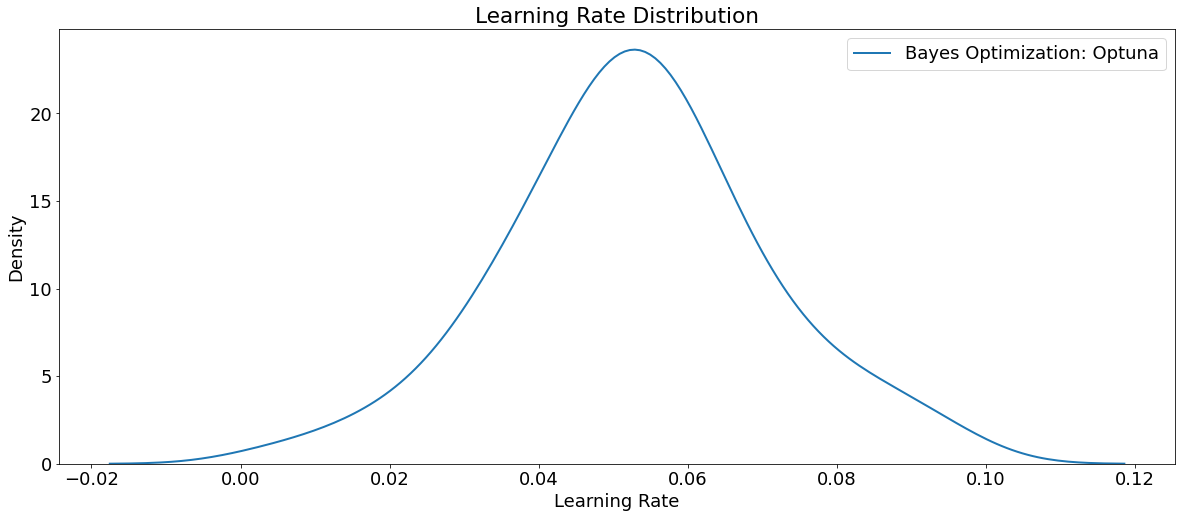

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label='Bayes Optimization: Optuna', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); 
plt.title('Learning Rate Distribution');
plt.show()

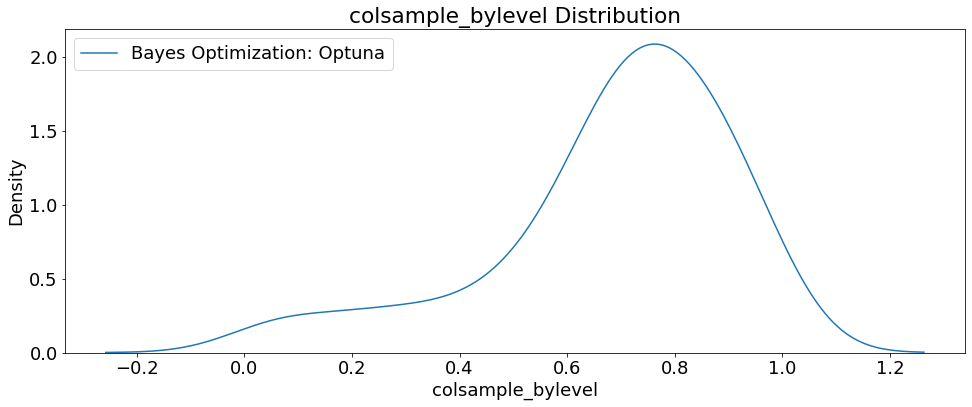

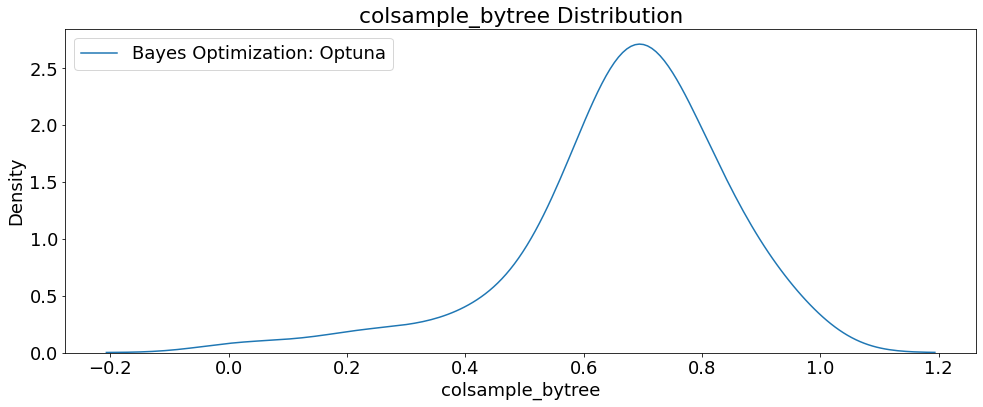

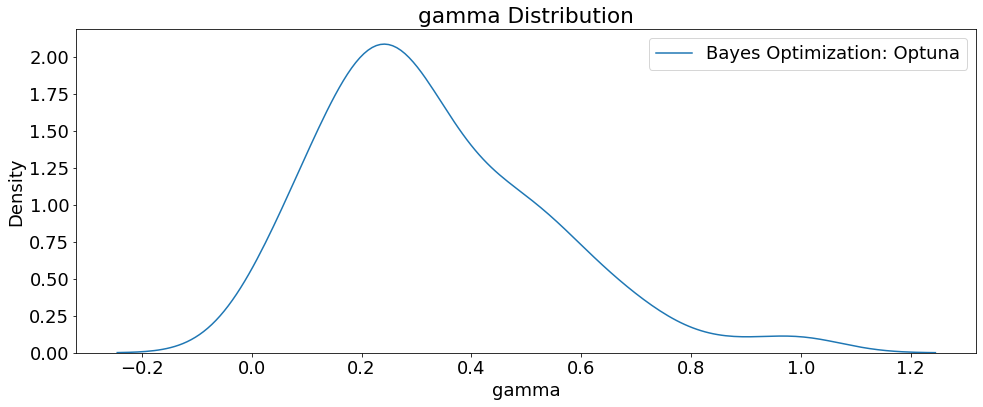

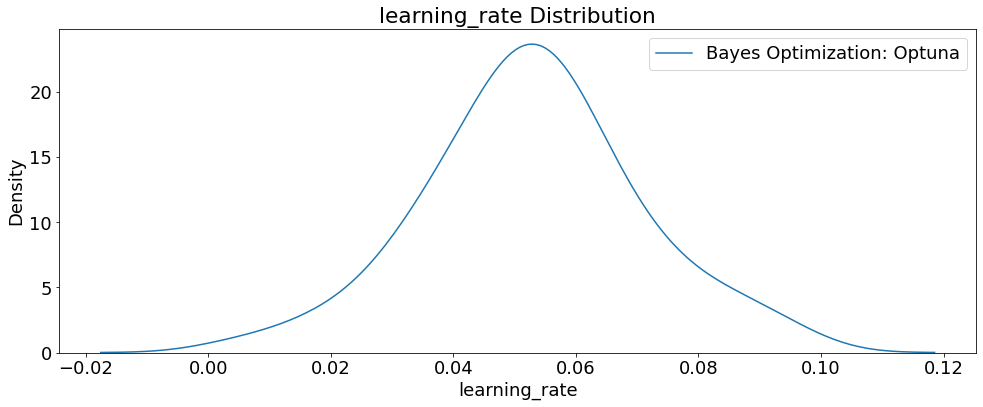

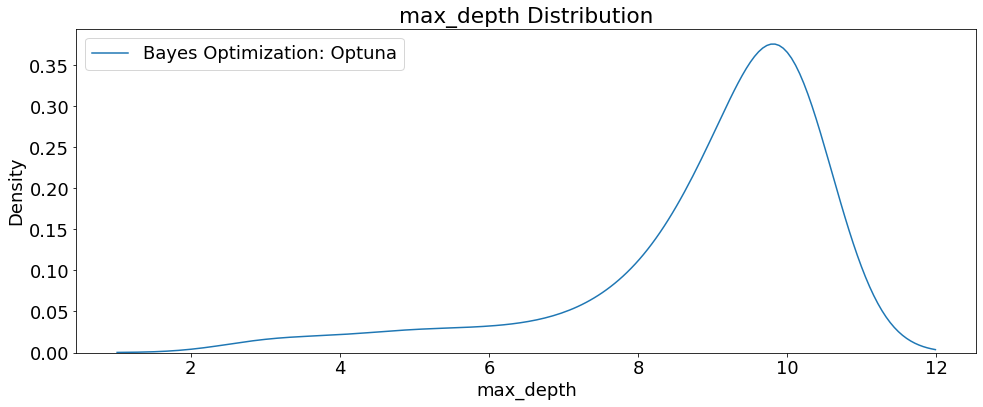

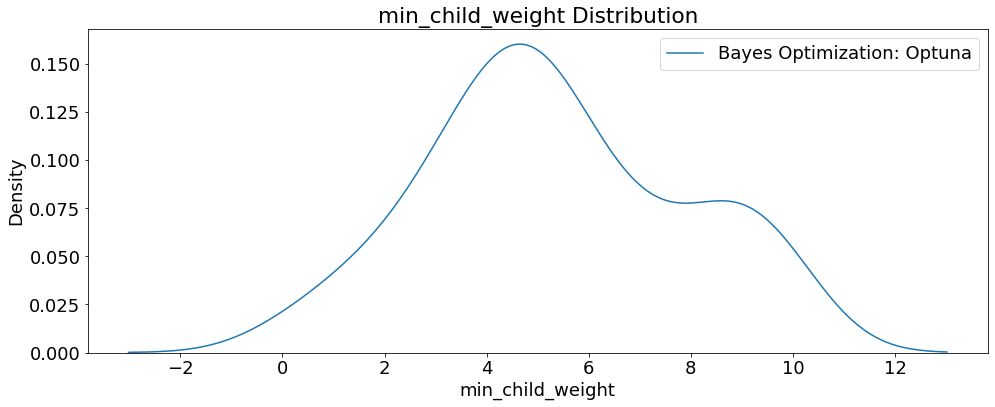

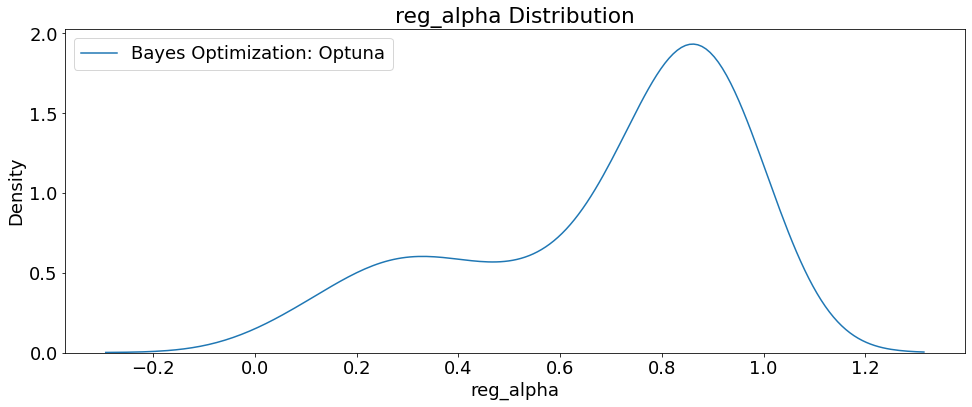

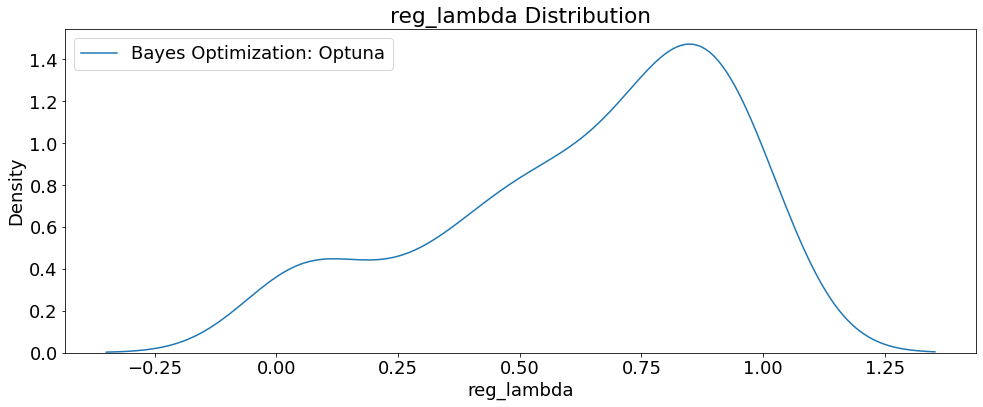

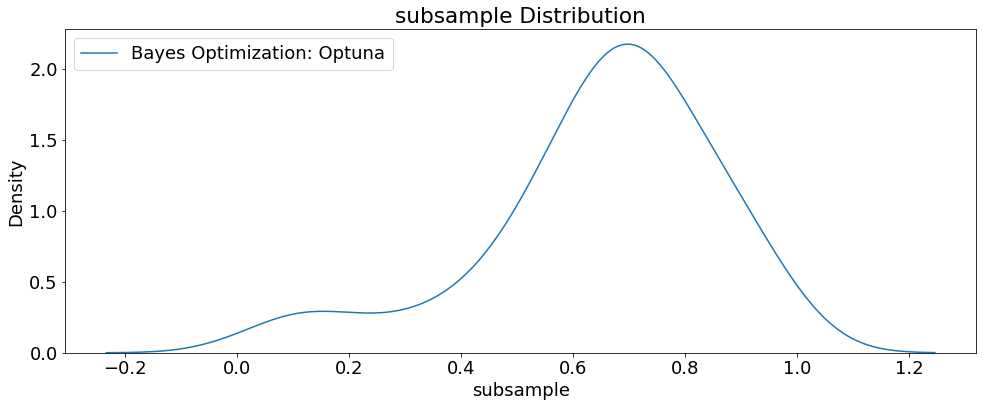

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

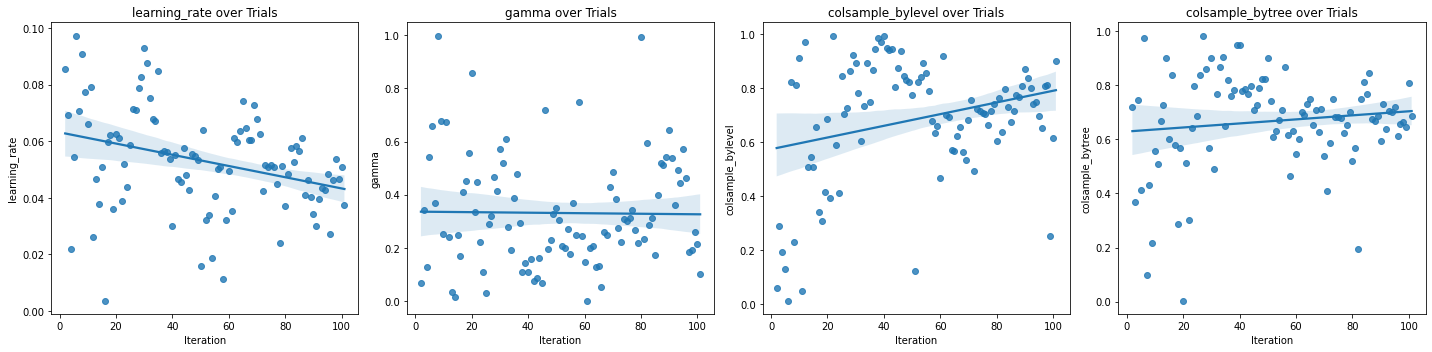

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

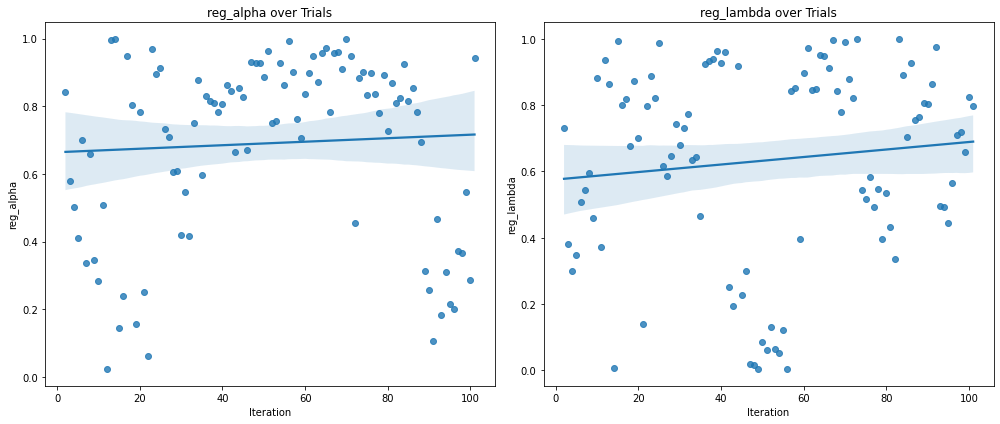

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14,6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']): 
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_XGBoost_Optuna_100_GPU_glove300d_balanced.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_XGBoost_Optuna_100_GPU_glove300d_balanced.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params['random_state'] = seed_value
params['loss_function']= 'Logloss'
params

{'n_estimators': 500,
 'max_depth': 10,
 'subsample': 0.7354548283203094,
 'gamma': 0.24840409860432594,
 'learning_rate': 0.05096322146555461,
 'reg_alpha': 0.9015366103543743,
 'reg_lambda': 0.8437471606641064,
 'colsample_bytree': 0.6147071521465948,
 'colsample_bylevel': 0.6757605300874406,
 'min_child_weight': 5,
 'random_state': 42,
 'loss_function': 'Logloss'}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/ML/XGBoost/ReviewStars/Model_PKL/

In [ ]:
# Set up label and features
label = df[['stars_reviews']]
features = df.cleanReview

# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, 
                                                    stratify=label)

In [ ]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [ ]:
# Re-create the best model and train on the training data
best_model = XGBClassifier(objective='binary:logistic',
                           booster='gbtree',
                           tree_method='gpu_hist',
                           scale_pos_weight=1,
                           use_label_encoder=False,
                           verbosity=0,
                           **params)

# Fit the model
best_model.fit(X_train, y_train.values.ravel())

# Save model
Pkl_Filename = 'XGBoost_HPO_Optuna_trials100_GPU_glove300d_balanced.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('XGBoost_HPO_Optuna_trials100_GPU_glove300d_balanced.pkl')
# print(model)
# =============================================================================

In [ ]:
print('Results from XGBoost HPO Optuna 100 GloVe GPU trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from Xgboost HPO Optuna 100 GloVe GPU trials:


Classification Report: Train
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96    331949
         1.0       0.96      0.96      0.96    331950

    accuracy                           0.96    663899
   macro avg       0.96      0.96      0.96    663899
weighted avg       0.96      0.96      0.96    663899



Confusion matrix: Train
[[319530  12419]
 [ 12937 319013]]


Classification Report: Test
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94     82988
         1.0       0.94      0.94      0.94     82987

    accuracy                           0.94    165975
   macro avg       0.94      0.94      0.94    165975
weighted avg       0.94      0.94      0.94    165975



Confusion matrix: Test
[[77941  5047]
 [ 5199 77788]]


Accuracy score: train: 0.962, test: 0.938
Precision score: train: 0.963, test: 0.939
Recall score: train: 0.961,

In [ ]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, 
                                                                                                       y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.93827 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    57
logloss                                0.157034
datetime_start       2022-09-06 07:42:51.742039
datetime_complete    2022-09-06 07:45:07.757980
duration                 0 days 00:02:16.015941
colsample_bylevel                      0.675761
colsample_bytree                       0.614707
gamma                                  0.248404
learning_rate                          0.050963
max_depth                                  10.0
min_child_weight                            5.0
n_estimators                              500.0
reg_alpha                              0.901537
reg_lambda                             0.843747
subsample                              0.735455
state                                  COMPLETE
Name: 0, dtype: object
